### Setup

In [1]:
# Import libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from importlib import reload
import numpy as np
from numpy.linalg import multi_dot
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, cophenet, inconsistent
from sklearn.metrics import adjusted_mutual_info_score, silhouette_score, silhouette_samples
import seaborn as sns
from scipy import sparse
import scipy.stats as ss
import csv
import pandas as pd
import networkx as nx
import community
import communities as com
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
import itertools
import os.path
import math
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_mutual_info_score
from networkx.algorithms.community.kclique import k_clique_communities
import pybedtools
import time
from tqdm import tqdm
import random
import OmicsIntegrator as oi
import gseapy
from gseapy.plot import barplot, dotplot
from ortools.linear_solver import pywraplp
from pyvis.network import Network
from scipy.spatial.distance import pdist, squareform
from umap import UMAP
# Custom libraries
import utils as lu
import correlation_clustering as cc
# Reload modules in case of modifications
reload(lu)
reload(cc)

<module 'correlation_clustering' from '/home/louiscam/projects/gpcr/code/figures4/correlation_clustering.py'>

In [2]:
# Relevant information
cell_type = 'IMR90'
resol_str = '250kb'
resol = 250000
quality = 'MAPQGE30'
norm = 'GWKR'

In [3]:
# Directory of genome data
dir_genome = '/home/louiscam/projects/gpcr/data/genome_data/'
# Directory of adhesome data
dir_adhesome = '/home/louiscam/projects/gpcr/data/adhesome_data/'
# Directory of processed HiC
dir_processed_hic = f'/home/louiscam/projects/gpcr/save/processed_hic_data/processed_hic_data_IMR90/final_BP250000_intraKR_inter{norm}/'
epigenome_dir = '/home/louiscam/projects/gpcr/data/regulatory_data/regulatory_data_IMR90/'
processed_epigenome_data_dir = '/home/louiscam/projects/gpcr/save/processed_regulatory_marks/processed_epigenome_data_IMR90/'
# Directpry of TF target data
dir_htftarget = '/home/louiscam/projects/gpcr/data/tf_data/hTFtarget/'
# Saving directory
saving_dir = '/home/louiscam/projects/gpcr/save/figures/'

# Load data

## General data

In [4]:
# Load gene location in hg19
gene_locations_filename = dir_genome+'chrom_hg19.loc_canonical'
gene_id_filename = dir_genome+'chrom_hg19.name'
df_loc = lu.get_all_gene_locations(gene_locations_filename, gene_id_filename)

In [5]:
# Active/inactive genes
with open(saving_dir+'active_genes.pkl', 'rb') as f:
    all_active_genes = pickle.load(f)
with open(saving_dir+'inactive_genes.pkl', 'rb') as f:
    all_inactive_genes = pickle.load(f)

In [6]:
# All TF data
tftarget_df = pd.read_csv(dir_htftarget+'tftarget_full_processed.csv', 
                          sep='\t', index_col=0, header=0, low_memory=False)
lung_fibroblasts = ['IMR90', 'WI38', 'AG04450', 'HPF', 'NHLF', ]
tftarget_df_lungfibro = tftarget_df[tftarget_df['cell_line'].isin(lung_fibroblasts)]

In [7]:
# Mapping gene to chromosome
with open(saving_dir+'gene2chrom.pkl', 'rb') as f:
    gene2chrom = pickle.load(f)

## Adhesome and adhesome TF data

In [8]:
# Adhesome genes and loci
with open(saving_dir+'active_adhesome_genes.pkl', 'rb') as f:
    active_adhesome_genes = pickle.load(f)
with open(saving_dir+'active_adhesome_genes_loci.pkl', 'rb') as f:
    active_adhesome_loci = pickle.load(f)
with open(saving_dir+'adhesome_chr_loci.pkl', 'rb') as f:
    adhesome_chr_loci = pickle.load(f)

In [9]:
# Adhesome TF genes and loci
with open(saving_dir+'active_lung_adhesome_tf_genes.pkl', 'rb') as f:
    active_lung_adhesome_tf_genes = pickle.load(f)
with open(saving_dir+'active_lung_adhesome_tf_loci.pkl', 'rb') as f:
    active_lung_adhesome_tf_loci = pickle.load(f)

In [12]:
# Selected genes = Adhesome genes + adhesome TFs
selected_genes = np.unique(np.concatenate([active_adhesome_genes,active_lung_adhesome_tf_genes], axis=0))
selected_loci = np.unique(np.concatenate([active_adhesome_loci,active_lung_adhesome_tf_loci], axis=0))
with open(saving_dir+'adh_and_tf_gene2locus.pkl', 'rb') as f:
    selected_gene2locus = pickle.load(f)
with open(saving_dir+'adh_and_tf_locus2gene.pkl', 'rb') as f:
    selected_locus2gene = pickle.load(f)
with open(saving_dir+'adh_and_tf_chr_loci.pkl', 'rb') as f:
    adh_and_tf_chr_loci = pickle.load(f)
with open(saving_dir+f'contacts_df_{norm}.pkl', 'rb') as f:
    contacts_df = pickle.load(f)

## Adhesome TFs map data

In [13]:
# Load hTFtarget data set
with open(saving_dir+'active_lung_tf2target.pkl', 'rb') as f:
    active_lung_tf2target = pickle.load(f)
with open(saving_dir+'active_lung_target2tf.pkl', 'rb') as f:
    active_lung_target2tf = pickle.load(f)

# Network of adhesome genes and adhesome TF genes

## Initial edges lists

### Network of adhesome genes: interX edges

### Network of adhesome genes: intraX edges

## HiC and correlation distances

In [16]:
# Load edge lists
with open(saving_dir+f'adhesome_interX_edge_list_{norm}.pkl', 'rb') as f:
    adhesome_interX_edge_list = pickle.load(f)
with open(saving_dir+f'adhesome_intraX_edge_list_{norm}.pkl', 'rb') as f:
    adhesome_intraX_edge_list = pickle.load(f)

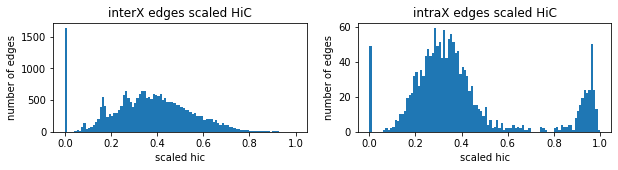

In [17]:
# Plot thresholds
plt.figure(figsize=(10,2))
plt.subplot(1, 2, 1)
plt.hist(adhesome_interX_edge_list['scaled_hic'], bins=np.arange(0,1.01,0.01))
# plt.vlines(x=np.quantile(adhesome_interX_edge_list['scaled_hic'],0.75), ymin=0, ymax=2000, 
#            color='red', linestyle='dashed')
plt.xlabel('scaled hic')
plt.ylabel('number of edges')
plt.title('interX edges scaled HiC')

plt.subplot(1, 2, 2)
plt.hist(adhesome_intraX_edge_list['scaled_hic'], bins=np.arange(0,1.01,0.01))
# plt.vlines(x=np.quantile(adhesome_intraX_edge_list['scaled_hic'],0.75), ymin=0, ymax=70, 
#            color='red', linestyle='dashed')
plt.xlabel('scaled hic')
plt.ylabel('number of edges')
plt.title('intraX edges scaled HiC')

plt.show()

### Genomic features for each adhesome gene

In [18]:
# Load epigenomic features
df_all_norm = pd.read_csv(saving_dir+'features_matrix_all_genes_norm.csv', header=0, index_col=0)
# Restrict to genes in cluster
df_cluster_norm = df_all_norm.loc[:,selected_genes]

In [19]:
# Create Pearson distance matrix
adhesome_pearson_distance_df = (1-df_cluster_norm.corr(method='pearson'))/2
# Create Spearman distance matrix
adhesome_spearman_distance_df = (1-df_cluster_norm.corr(method='spearman'))/2
# Create cosine distance matrix
adhesome_cosine_df = pd.DataFrame(
    squareform(pdist(df_cluster_norm.T, metric='cosine')),
    columns = df_cluster_norm.columns,
    index = df_cluster_norm.columns
)/2

In [20]:
# Add distance and Spearman correlation to interX edge list
adhesome_interX_edge_list['pearson_dist'] = [adhesome_pearson_distance_df.loc[adhesome_interX_edge_list.iloc[i]['source'],
                                                                              adhesome_interX_edge_list.iloc[i]['target']]
                                              for i in range(len(adhesome_interX_edge_list))]
adhesome_interX_edge_list['spearman_dist'] = [adhesome_spearman_distance_df.loc[adhesome_interX_edge_list.iloc[i]['source'],
                                                                                adhesome_interX_edge_list.iloc[i]['target']]
                                              for i in range(len(adhesome_interX_edge_list))]
adhesome_interX_edge_list['cosine_dist'] = [adhesome_cosine_df.loc[adhesome_interX_edge_list.iloc[i]['source'],
                                                                                adhesome_interX_edge_list.iloc[i]['target']]
                                              for i in range(len(adhesome_interX_edge_list))]
# Add distance and Spearman correlation to intraX edge list
adhesome_intraX_edge_list['pearson_dist'] = [adhesome_pearson_distance_df.loc[adhesome_intraX_edge_list.iloc[i]['source'],
                                                                              adhesome_intraX_edge_list.iloc[i]['target']]
                                              for i in range(len(adhesome_intraX_edge_list))]
adhesome_intraX_edge_list['spearman_dist'] = [adhesome_spearman_distance_df.loc[adhesome_intraX_edge_list.iloc[i]['source'],
                                                                                adhesome_intraX_edge_list.iloc[i]['target']]
                                              for i in range(len(adhesome_intraX_edge_list))]
adhesome_intraX_edge_list['cosine_dist'] = [adhesome_cosine_df.loc[adhesome_intraX_edge_list.iloc[i]['source'],
                                                                                adhesome_intraX_edge_list.iloc[i]['target']]
                                              for i in range(len(adhesome_intraX_edge_list))]
print('Total number of edges = '+str(len(adhesome_intraX_edge_list)+len(adhesome_interX_edge_list)))

Total number of edges = 26106


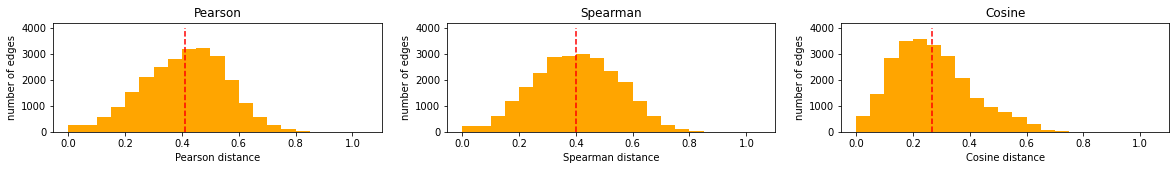

In [21]:
# Plot distribution of distance in selected edges
hic_threshold = 0.
t = np.quantile(adhesome_interX_edge_list['scaled_hic'],hic_threshold)
u = np.quantile(adhesome_intraX_edge_list['scaled_hic'],hic_threshold)
inter_selected = adhesome_interX_edge_list[adhesome_interX_edge_list['scaled_hic']>t]
intra_selected = adhesome_intraX_edge_list[adhesome_intraX_edge_list['scaled_hic']>u][['source','target',
                                                                                       'hic','scaled_hic',
                                                                                       'pearson_dist','spearman_dist',
                                                                                       'cosine_dist']]
all_selected = pd.concat([inter_selected, intra_selected], axis=0)
plt.figure(figsize=(20,2))
# Pearson
plt.subplot(1, 3, 1)
plt.hist(all_selected['pearson_dist'], 
         bins=np.arange(0,1.1,0.05),
        color='orange')
plt.vlines(x=np.mean(all_selected['pearson_dist']), ymin=0, ymax=4000, color='red', linestyle='dashed')
plt.xlabel('Pearson distance')
plt.ylabel('number of edges')
plt.title('Pearson')

# Spearman
plt.subplot(1, 3, 2)
plt.hist(all_selected['spearman_dist'], 
         bins=np.arange(0,1.1,0.05),
        color='orange')
plt.vlines(x=np.mean(all_selected['spearman_dist']), ymin=0, ymax=4000, color='red', linestyle='dashed')
plt.xlabel('Spearman distance')
plt.ylabel('number of edges')
plt.title('Spearman')

# Cosine
plt.subplot(1, 3, 3)
plt.hist(all_selected['cosine_dist'], 
         bins=np.arange(0,1.1,0.05),
        color='orange')
plt.vlines(x=np.mean(all_selected['cosine_dist']), ymin=0, ymax=4000, color='red', linestyle='dashed')
plt.xlabel('Cosine distance')
plt.ylabel('number of edges')
plt.title('Cosine')

plt.show()

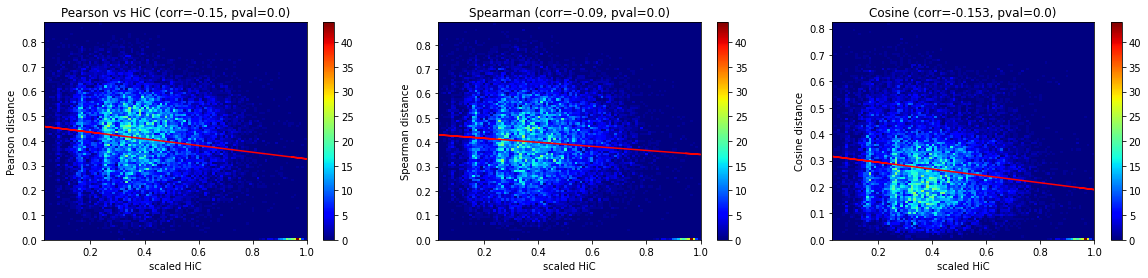

In [22]:
# Plot relationship between HiC and correlation distance
hic_threshold = 0.
t = np.quantile(adhesome_interX_edge_list['scaled_hic'],hic_threshold)
u = np.quantile(adhesome_intraX_edge_list['scaled_hic'],hic_threshold)
inter_selected = adhesome_interX_edge_list[adhesome_interX_edge_list['scaled_hic']>0]
intra_selected = adhesome_intraX_edge_list[adhesome_intraX_edge_list['scaled_hic']>0][['source','target',
                                                                                       'hic','scaled_hic',
                                                                                       'pearson_dist','spearman_dist',
                                                                                       'cosine_dist']]
all_selected = pd.concat([inter_selected, intra_selected], axis=0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4))
# Pearson
x = all_selected['scaled_hic']
y = all_selected['pearson_dist']
h1 = ax1.hist2d(x, y, (100, 100), cmap=plt.cm.jet)
m, b = np.polyfit(x, y, 1)
ax1.plot(x, m*x+b, color='red')
ax1.set_xlabel('scaled HiC')
ax1.set_ylabel('Pearson distance')
fig.colorbar(h1[3], ax=ax1)
pearson = ss.pearsonr(x,y)
ax1.set_title('Pearson vs HiC (corr='+str(np.round(pearson[0],3))+', pval='+str(np.round(pearson[1],3))+')')

# Spearman
x = all_selected['scaled_hic']
y = all_selected['spearman_dist']
h2 = ax2.hist2d(x, y, (100, 100), cmap=plt.cm.jet)
m, b = np.polyfit(x, y, 1)
ax2.plot(x, m*x+b, color='red')
ax2.set_xlabel('scaled HiC')
ax2.set_ylabel('Spearman distance')
fig.colorbar(h2[3], ax=ax2)
pearson = ss.pearsonr(x,y)
ax2.set_title('Spearman (corr='+str(np.round(pearson[0],3))+', pval='+str(np.round(pearson[1],3))+')')

# Cosine
x = all_selected['scaled_hic']
y = all_selected['cosine_dist']
h3 = ax3.hist2d(x, y, (100, 100), cmap=plt.cm.jet)
m, b = np.polyfit(x, y, 1)
ax3.plot(x, m*x+b, color='red')
ax3.set_xlabel('scaled HiC')
ax3.set_ylabel('Cosine distance')
fig.colorbar(h3[3], ax=ax3)
pearson = ss.pearsonr(x,y)
ax3.set_title('Cosine (corr='+str(np.round(pearson[0],3))+', pval='+str(np.round(pearson[1],3))+')')
plt.show()

## ROC-type curves for choice of distance

In [19]:
# Create list of selected edges
hic_threshold = 0.
t = np.quantile(adhesome_interX_edge_list['scaled_hic'],hic_threshold)
u = np.quantile(adhesome_intraX_edge_list['scaled_hic'],hic_threshold)
inter_selected = adhesome_interX_edge_list[adhesome_interX_edge_list['scaled_hic']>=t]
intra_selected = adhesome_intraX_edge_list[adhesome_intraX_edge_list['scaled_hic']>=u][['source','target',
                                                                                       'hic','scaled_hic',
                                                                                       'pearson_dist','spearman_dist',
                                                                                       'cosine_dist']]
all_selected = pd.concat([inter_selected, intra_selected], axis=0)

100%|██████████| 29646/29646 [01:23<00:00, 356.42it/s] 


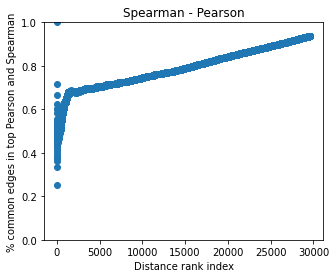

 73%|███████▎  | 21765/29646 [00:44<00:32, 244.11it/s] 

KeyboardInterrupt: 

In [19]:
# Plot ROC-type curves for all pairs of distances
rank_thresh_list = np.arange(1,len(all_selected)+1)

# Edge list sorted by Pearson, Spearman and cosine distance
all_selected_pearson = all_selected.sort_values(by='pearson_dist', ascending=True).index.values
all_selected_spearman = all_selected.sort_values(by='spearman_dist', ascending=True).index.values
all_selected_cosine= all_selected.sort_values(by='cosine_dist', ascending=True).index.values

# Spearman and Pearson
ls_pct = []
for t in tqdm(rank_thresh_list):
    lowest_dist_1 = set(all_selected_pearson[:t])
    lowest_dist_2 = set(all_selected_spearman[:t])
    pct = len(lowest_dist_1.intersection(lowest_dist_2))/t
    ls_pct.append(pct)
plt.figure(figsize=(5,4))
plt.scatter(rank_thresh_list, ls_pct)
plt.ylim(0,1)
plt.xlabel('Distance rank index')
plt.ylabel('% common edges in top Pearson and Spearman')
plt.title('Spearman - Pearson')
plt.show()

# Pearson and cosine
ls_pct = []
for t in tqdm(rank_thresh_list):
    lowest_dist_1 = set(all_selected_pearson[:t])
    lowest_dist_2 = set(all_selected_cosine[:t])
    pct = len(lowest_dist_1.intersection(lowest_dist_2))/t
    ls_pct.append(pct)
plt.figure(figsize=(5,4))
plt.scatter(rank_thresh_list, ls_pct)
plt.ylim(0,1)
plt.xlabel('Distance rank index')
plt.ylabel('% common edges in top Pearson and cosine')
plt.title('Pearson - cosine')
plt.show()

# Spearman and cosine
ls_pct = []
for t in tqdm(rank_thresh_list):
    lowest_dist_1 = set(all_selected_cosine[:t])
    lowest_dist_2 = set(all_selected_spearman[:t])
    pct = len(lowest_dist_1.intersection(lowest_dist_2))/t
    ls_pct.append(pct)
plt.figure(figsize=(5,4))
plt.scatter(rank_thresh_list, ls_pct)
plt.ylim(0,1)
plt.xlabel('Distance rank index')
plt.ylabel('% common edges in top Spearman and cosine')
plt.title('Spearman - cosine')
plt.show()

# Spearman, Pearson and cosine
ls_pct = []
for t in tqdm(rank_thresh_list):
    lowest_dist_1 = set(all_selected_pearson[:t])
    lowest_dist_2 = set(all_selected_spearman[:t])
    lowest_dist_3 = set(all_selected_cosine[:t])
    pct = len(lowest_dist_1.intersection(lowest_dist_2).intersection(lowest_dist_3))/t
    ls_pct.append(pct)
plt.figure(figsize=(5,4))
plt.scatter(rank_thresh_list, ls_pct)
plt.ylim(0,1)
plt.xlabel('Distance rank index')
plt.ylabel('% common edges in top Pearson, Spearman and cosine')
plt.title('Pearson - Spearman - cosine')
plt.show()


## Compare HiC clusters and regulatory clusters

### Get HiC clusters

In [20]:
# Construct network
inter_selected = adhesome_interX_edge_list.copy()
intra_selected = adhesome_intraX_edge_list.copy()
intra_selected = intra_selected[['source','target','hic','scaled_hic',
                                 'pearson_dist','spearman_dist',
                                 'cosine_dist']]
adhesome_edge_list = pd.concat([inter_selected,intra_selected], axis=0)
G = nx.from_pandas_edgelist(adhesome_edge_list, edge_attr=['hic','scaled_hic',
                                                           'pearson_dist','spearman_dist',
                                                           'cosine_dist'])
G.add_nodes_from(selected_genes)
dist_hic = 1-np.array(nx.adjacency_matrix(G, nodelist=sorted(G.nodes), weight='scaled_hic').todense())
np.fill_diagonal(dist_hic,0)
y = dist_hic[np.triu_indices(n=len(dist_hic),k=1)]

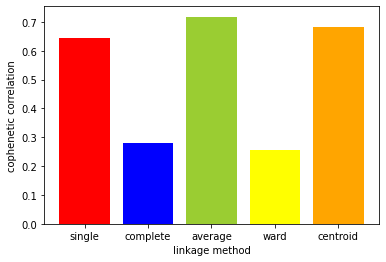

In [21]:
# Check which is the best technique in terms of cophenetic correlation
cophenet_single = cophenet(linkage(y, method='single'), y)[0]
cophenet_complete = cophenet(linkage(y, method='complete'), y)[0]
cophenet_average = cophenet(linkage(y, method='average'), y)[0]
cophenet_ward = cophenet(linkage(y, method='ward'), y)[0]
cophenet_centroid = cophenet(linkage(y, method='centroid'), y)[0]
plt.figure()
plt.bar(x=['single', 'complete', 'average', 'ward', 'centroid'],
        height = [cophenet_single, cophenet_complete, cophenet_average, cophenet_ward, cophenet_centroid],
        color = ['red', 'blue', 'yellowgreen', 'yellow', 'orange'])
plt.xlabel('linkage method')
plt.ylabel('cophenetic correlation')
plt.show()

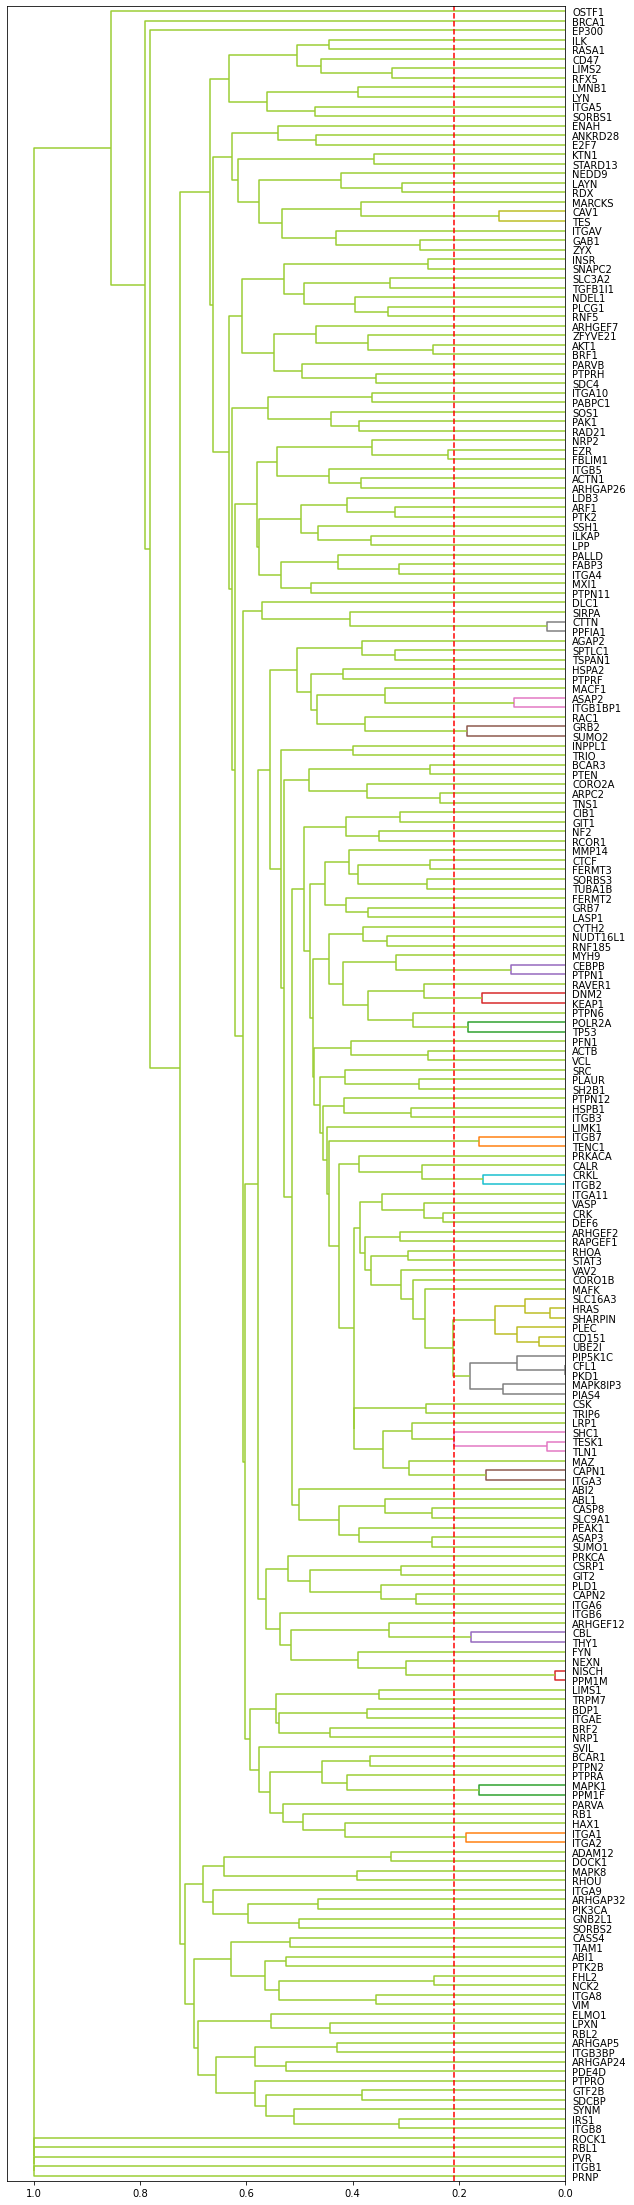

In [22]:
# Cluster using average linkage
linked1 = linkage(y, method='average')
t1 = cc.get_4chrom_clustering(linked1, sorted(G.nodes), gene2chrom)
clust1 = fcluster(linked1, t1, criterion='distance')
plt.figure(figsize=(10, 40))
dendrogram(linked1,
            orientation='left',
            labels=sorted(G.nodes),
            no_labels=False,
            distance_sort='descending',
            show_leaf_counts=True,
            leaf_font_size=10,
            color_threshold=t1, above_threshold_color='yellowgreen')
plt.vlines(x=t1, ymin=0, ymax=4000, color='red', linestyle='dashed')
plt.show()

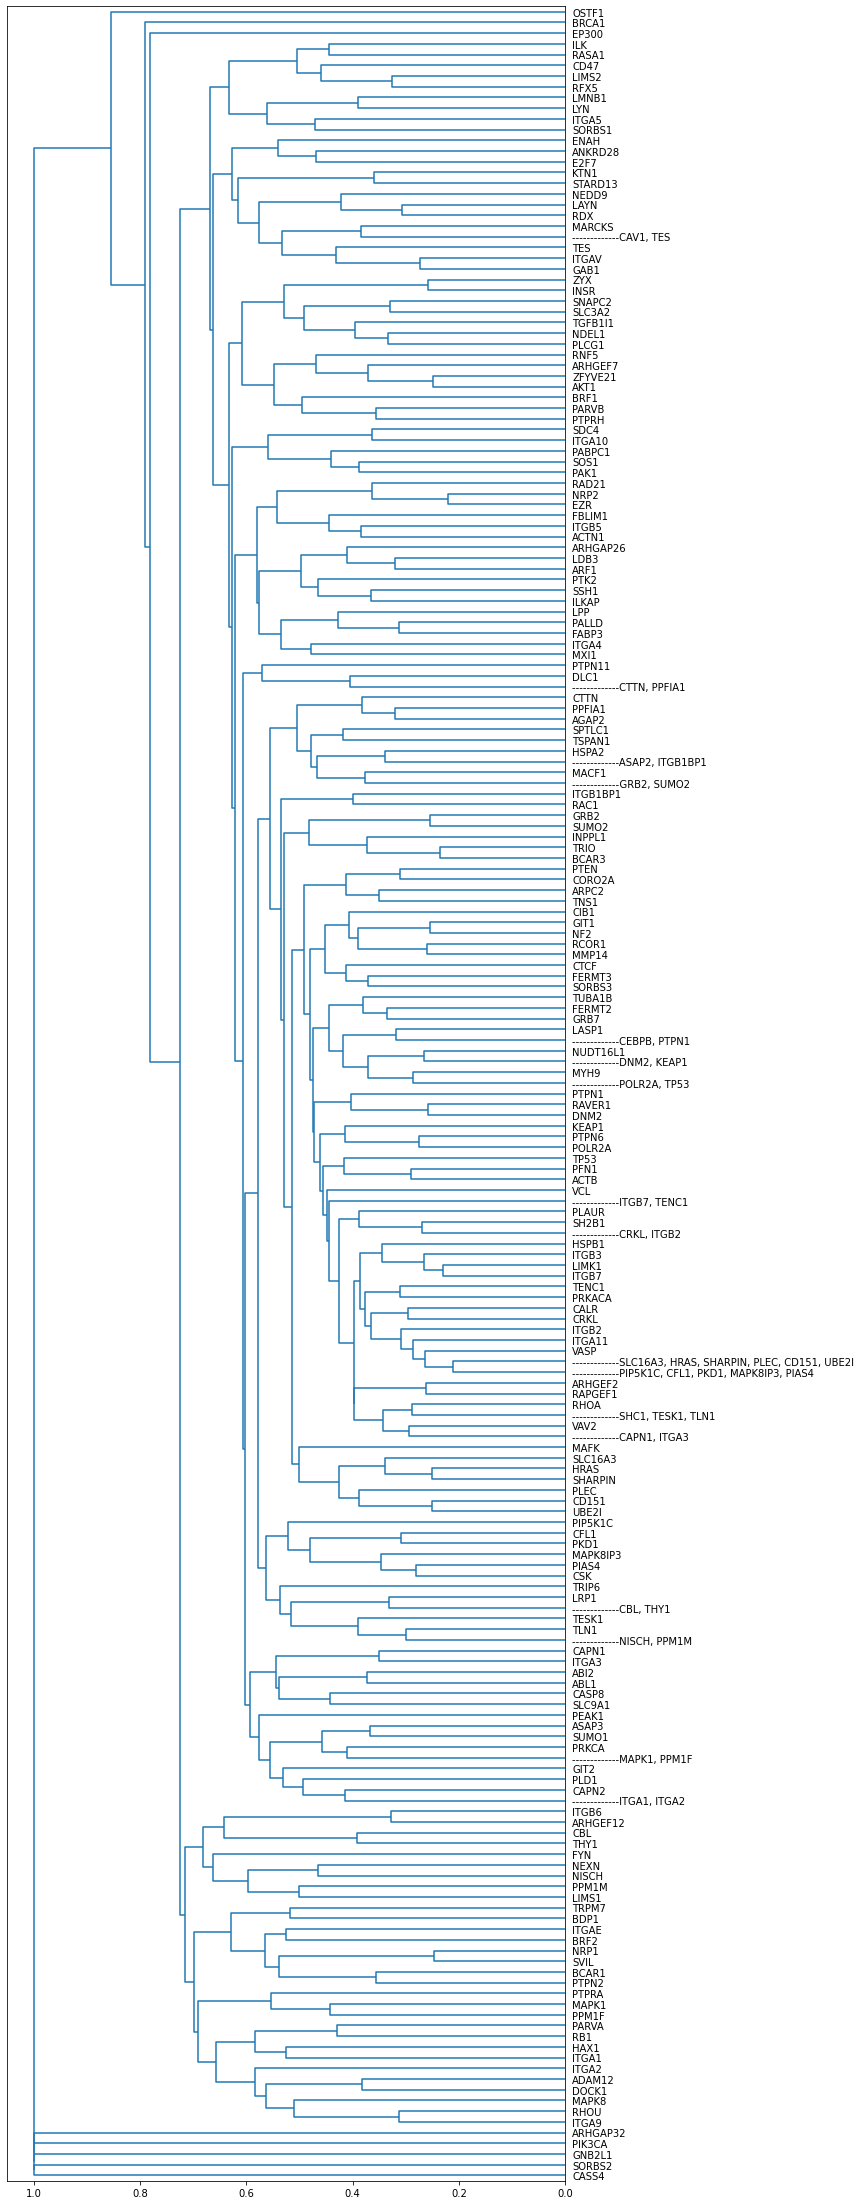

In [23]:
# Perform HC with average linkage
linked1 = linkage(y, method='average')
t1 = cc.get_4chrom_clustering(linked1, sorted(G.nodes), gene2chrom)
clust1 = fcluster(linked1, t1, criterion='distance')
# Call dendrogram to get the returned dictionary and compute label function
R1 = dendrogram(linked1, labels=sorted(G.nodes), no_plot=True)
R2 = dendrogram(linked1, labels=sorted(G.nodes), p=len(np.unique(clust1)), truncate_mode='lastp', no_plot=True)
R3 = []
c = 0
for i in range(len(R2['ivl'])):
    if ('(' not in R2['ivl'][i]):
        R3.append(R1['ivl'][i])
    else:
        k = int(R2['ivl'][i].strip('()'))
        R3.append('-------------'+', '.join(np.array(R1['ivl'])[(i+c):(i+c+k)]))
        c = c+k-1
# Create a label dictionary
temp = {
    R2['leaves'][ii]: R3[ii] 
    for ii in range(len(R2['leaves']))
}
def llf(xx):
    return temp[xx]

plt.figure(figsize=(10, 40))
dendrogram(linked1,
            orientation='left',
            labels=sorted(G.nodes),
            distance_sort='descending',
            leaf_font_size=10,
            p=len(np.unique(clust1)), truncate_mode='lastp', leaf_label_func=llf,
            color_threshold=0)
plt.show()

In [24]:
# Get clustering dataframe
clustering_hic_df = pd.DataFrame({'gene': sorted(G.nodes),
                                  'chrom': [gene2chrom[g] for g in sorted(G.nodes)],
                                  'cluster': clust1})
clustering_hic_df = clustering_hic_df.groupby('cluster').agg({'gene': lambda x: list(x),
                                                              'chrom': lambda x: list(x)})
clustering_hic_df['unique_chrom'] = [set(ls) for ls in clustering_hic_df['chrom']]
clustering_hic_df['size'] = [len(ls) for ls in clustering_hic_df['gene']]
clustering_hic_df1 = clustering_hic_df[clustering_hic_df['size']>1]
clustering_hic_df1 = clustering_hic_df1.sort_values(by='size', ascending=False)
clustering_hic_df1

,gene,chrom,unique_chrom,size
cluster,,,,
120,"[CD151, HRAS, PLEC, SHARPIN, SLC16A3, UBE2I]","[chr11, chr11, chr8, chr8, chr17, chr16]","{chr8, chr16, chr17, chr11}",6
121,"[CFL1, MAPK8IP3, PIAS4, PIP5K1C, PKD1]","[chr11, chr16, chr19, chr19, chr16]","{chr19, chr16, chr11}",5
127,"[SHC1, TESK1, TLN1]","[chr1, chr9, chr9]","{chr1, chr9}",3
18,"[CAV1, TES]","[chr7, chr7]",{chr7},2
159,"[MAPK1, PPM1F]","[chr22, chr22]",{chr22},2
147,"[NISCH, PPM1M]","[chr3, chr3]",{chr3},2
145,"[CBL, THY1]","[chr11, chr11]",{chr11},2
129,"[CAPN1, ITGA3]","[chr11, chr17]","{chr17, chr11}",2
109,"[CRKL, ITGB2]","[chr22, chr21]","{chr21, chr22}",2


### Get regulatory clusters

In [25]:
# Construct network
inter_selected = adhesome_interX_edge_list.copy()
intra_selected = adhesome_intraX_edge_list.copy()
intra_selected = intra_selected[['source','target','hic','scaled_hic',
                                 'pearson_dist','spearman_dist',
                                 'cosine_dist']]
adhesome_edge_list = pd.concat([inter_selected,intra_selected], axis=0)
G = nx.from_pandas_edgelist(adhesome_edge_list, edge_attr=['hic','scaled_hic',
                                                           'pearson_dist','spearman_dist',
                                                           'cosine_dist'])
G.add_nodes_from(selected_genes)

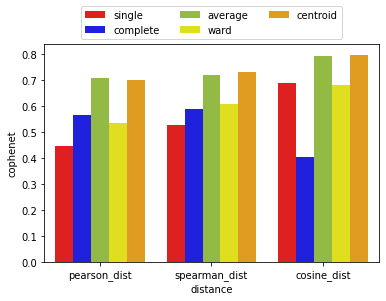

In [26]:
# Check which is the best technique in terms of cophenetic correlation
cophenet_df = pd.DataFrame(columns=['distance', 'linkage', 'cophenet'])

for dist in ['pearson_dist', 'spearman_dist', 'cosine_dist']:
    for link in ['single', 'complete', 'average', 'ward', 'centroid']:
        dist_mat = np.array(nx.adjacency_matrix(G, nodelist=sorted(G.nodes), weight=dist).todense())
        np.fill_diagonal(dist_mat,0)
        y = dist_mat[np.triu_indices(n=len(dist_mat),k=1)]
        cophenet_corr = cophenet(linkage(y, method=link), y)[0]
        cophenet_df = pd.concat([cophenet_df, pd.DataFrame({'distance': [dist], 'linkage': link, 'cophenet':cophenet_corr})], 
                                axis=0)
plt.figure()
sns.barplot(x='distance', y='cophenet', hue='linkage', data=cophenet_df,
            palette={'single':'red', 
                     'complete':'blue', 
                     'average':'yellowgreen', 
                     'ward':'yellow', 
                     'centroid':'orange'})
plt.legend(loc='center', bbox_to_anchor=(0.5,1.1), ncol=3)
plt.show()

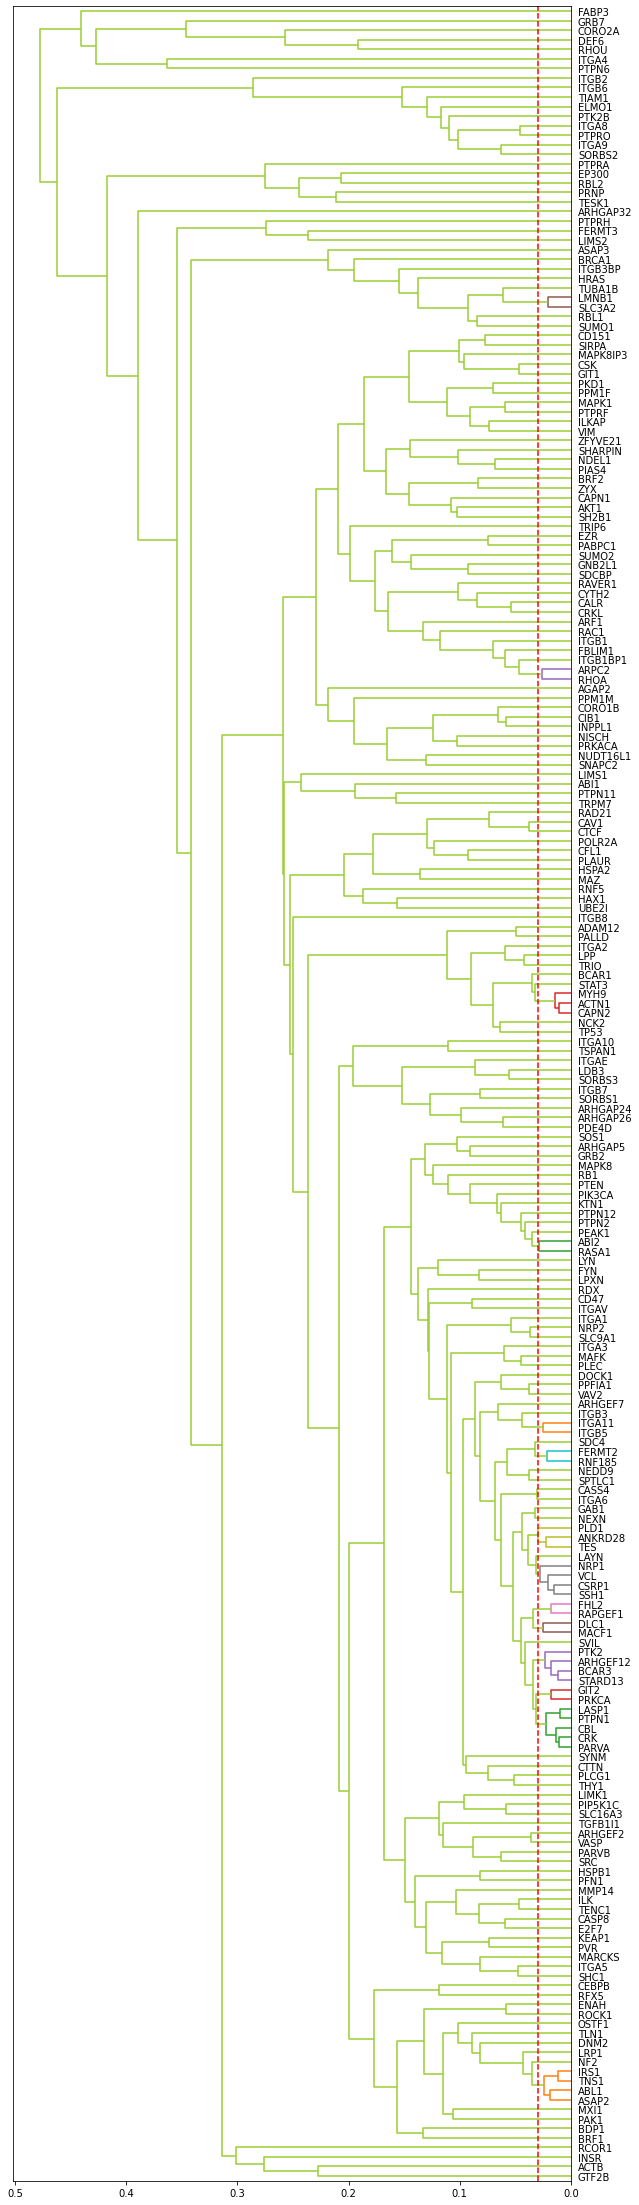

In [27]:
# Cluster using average linkage and cosine distance
dist_mat = np.array(nx.adjacency_matrix(G, nodelist=sorted(G.nodes), weight='cosine_dist').todense())
np.fill_diagonal(dist_mat,0)
y = dist_mat[np.triu_indices(n=len(dist_mat),k=1)]
linked2 = linkage(y, method='average')
t2 = cc.get_4chrom_clustering(linked2, sorted(G.nodes), gene2chrom, max_chrom=5)
clust2 = fcluster(linked2, t2, criterion='distance')
plt.figure(figsize=(10, 40))
dendrogram(linked2,
            orientation='left',
            labels=sorted(G.nodes),
            distance_sort='descending',
            show_leaf_counts=True,
            leaf_font_size=10,
            color_threshold=t2, above_threshold_color='yellowgreen')
plt.vlines(x=t2, ymin=0, ymax=4000, color='red', linestyle='dashed')
plt.show()

In [28]:
# Get clustering dataframe
clustering_hic_df = pd.DataFrame({'gene': sorted(G.nodes),
                                  'chrom': [gene2chrom[g] for g in sorted(G.nodes)],
                                  'cluster': clust2})
clustering_hic_df = clustering_hic_df.groupby('cluster').agg({'gene': lambda x: list(x),
                                                              'chrom': lambda x: list(x)})
clustering_hic_df['unique_chrom'] = [set(ls) for ls in clustering_hic_df['chrom']]
clustering_hic_df['size'] = [len(ls) for ls in clustering_hic_df['gene']]
clustering_hic_df2 = clustering_hic_df[clustering_hic_df['size']>1]
clustering_hic_df2 = clustering_hic_df2.sort_values(by='size', ascending=False)
clustering_hic_df2

,gene,chrom,unique_chrom,size
cluster,,,,
157,"[CBL, CRK, LASP1, PARVA, PTPN1]","[chr11, chr17, chr17, chr11, chr20]","{chr20, chr17, chr11}",5
151,"[CSRP1, NRP1, SSH1, VCL]","[chr1, chr10, chr12, chr10]","{chr12, chr1, chr10}",4
155,"[ARHGEF12, BCAR3, PTK2, STARD13]","[chr11, chr1, chr8, chr13]","{chr8, chr13, chr1, chr11}",4
188,"[ABL1, ASAP2, IRS1, TNS1]","[chr9, chr2, chr2, chr2]","{chr2, chr9}",4
98,"[ACTN1, CAPN2, MYH9]","[chr14, chr1, chr22]","{chr14, chr1, chr22}",3
150,"[ANKRD28, PLD1, TES]","[chr3, chr3, chr7]","{chr3, chr7}",3
25,"[LMNB1, SLC3A2]","[chr5, chr11]","{chr11, chr5}",2
62,"[ARPC2, RHOA]","[chr2, chr3]","{chr2, chr3}",2
116,"[ABI2, RASA1]","[chr2, chr5]","{chr2, chr5}",2


# Find clusters of adhesome genes

## Clusters based on HiC

In [29]:
# Construct network
inter_selected = adhesome_interX_edge_list.copy()
intra_selected = adhesome_intraX_edge_list.copy()
intra_selected = intra_selected[['source','target','hic','scaled_hic',
                                 'pearson_dist','spearman_dist',
                                 'cosine_dist']]
adhesome_edge_list = pd.concat([inter_selected,intra_selected], axis=0)
G = nx.from_pandas_edgelist(adhesome_edge_list, edge_attr=['hic','scaled_hic',
                                                           'pearson_dist','spearman_dist',
                                                           'cosine_dist'])
G.add_nodes_from(selected_genes)
dist_hic = 1-np.array(nx.adjacency_matrix(G, nodelist=sorted(G.nodes), weight='scaled_hic').todense())
np.fill_diagonal(dist_hic,0)
y = dist_hic[np.triu_indices(n=len(dist_hic),k=1)]

### Find threshold to obtain max 4 chromosomes per cluster

In [30]:
# Perform HC with various thresholds
threshold_list = np.arange(0,1,0.01)
n_clusters = []
max_genes_per_cluster = []
max_chrom_per_cluster = []
for hc_threshold in tqdm(threshold_list):
    # Cluster
    linked = linkage(y, method='average')
    clustering = fcluster(linked, t=hc_threshold, criterion='distance')
    # Create graph with metadata
    G_tmp = G.copy()
    labels = np.array(sorted(G_tmp.nodes))
    n = len(labels)
    nx.set_node_attributes(G_tmp, {labels[i]: str(clustering[i]) for i in range(n)}, "cluster")
    nx.set_node_attributes(G_tmp, {labels[i]: gene2chrom[labels[i]] for i in range(n)}, "chromosome")
    # Record results
    n_clusters.append(len(np.unique(clustering)))
    max_genes_per_cluster.append(np.max(np.unique(clustering, return_counts=True)[1]))
    max_chrom_per_cluster.append(oi.get_networkx_graph_as_dataframe_of_nodes(G_tmp).groupby('cluster')['chromosome'].nunique().max())
n_clusters = np.array(n_clusters)
max_genes_per_cluster = np.array(max_genes_per_cluster)
max_chrom_per_cluster = np.array(max_chrom_per_cluster)

100%|██████████| 100/100 [00:08<00:00, 11.84it/s]


Threshold = 0.21


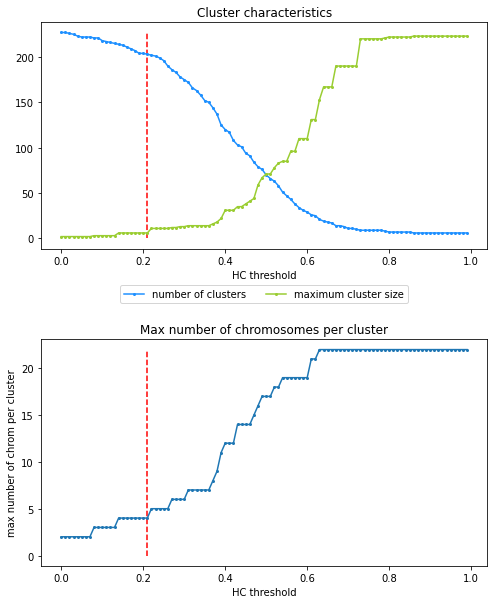

In [31]:
# Performance of different HC thresholds
t_critic = threshold_list[np.min(np.where(np.array(max_chrom_per_cluster)>4)[0])-1]
print('Threshold = '+str(t_critic))
plt.figure(figsize=(8,10))
plt.subplots_adjust(hspace=.4)

plt.subplot(2, 1, 1)
plt.plot(threshold_list, n_clusters, 
         marker='o', markersize=2, color='dodgerblue', label='number of clusters')
plt.plot(threshold_list, max_genes_per_cluster, 
         marker='o', markersize=2, color='yellowgreen', label='maximum cluster size')
plt.vlines(x=t_critic, ymin=0, ymax=max(n_clusters), color='red', linestyle='dashed')
plt.xlabel('HC threshold')
plt.ylabel('')
plt.legend(loc='center', bbox_to_anchor=(0.5,-0.2), ncol=2)
plt.title('Cluster characteristics')

plt.subplot(2, 1, 2)
plt.plot(threshold_list, max_chrom_per_cluster,
         marker='o', markersize=2)
plt.vlines(x=t_critic, ymin=0, ymax=max(max_chrom_per_cluster), color='red', linestyle='dashed')
plt.xlabel('HC threshold')
plt.ylabel('max number of chrom per cluster')
plt.title('Max number of chromosomes per cluster')
plt.show()

### HiC clustering with max 4 chromosomes per cluster

In [32]:
# Run hierarchical clustering
linked = linkage(y, method='average')
t = cc.get_4chrom_clustering(linked, sorted(G.nodes), gene2chrom, max_chrom=4)
clust = fcluster(linked, t, criterion='distance')

In [33]:
# Identify which nodes are in non-singleton clusters
gene_clusters_df = pd.DataFrame({'gene': sorted(G.nodes), 'cluster': clust})
nonsingleton_cluster_ids = set([c for c in list(clust) if list(clust).count(c)>1])
nonsingleton_genes = gene_clusters_df[gene_clusters_df['cluster'].isin(nonsingleton_cluster_ids)]['gene'].values

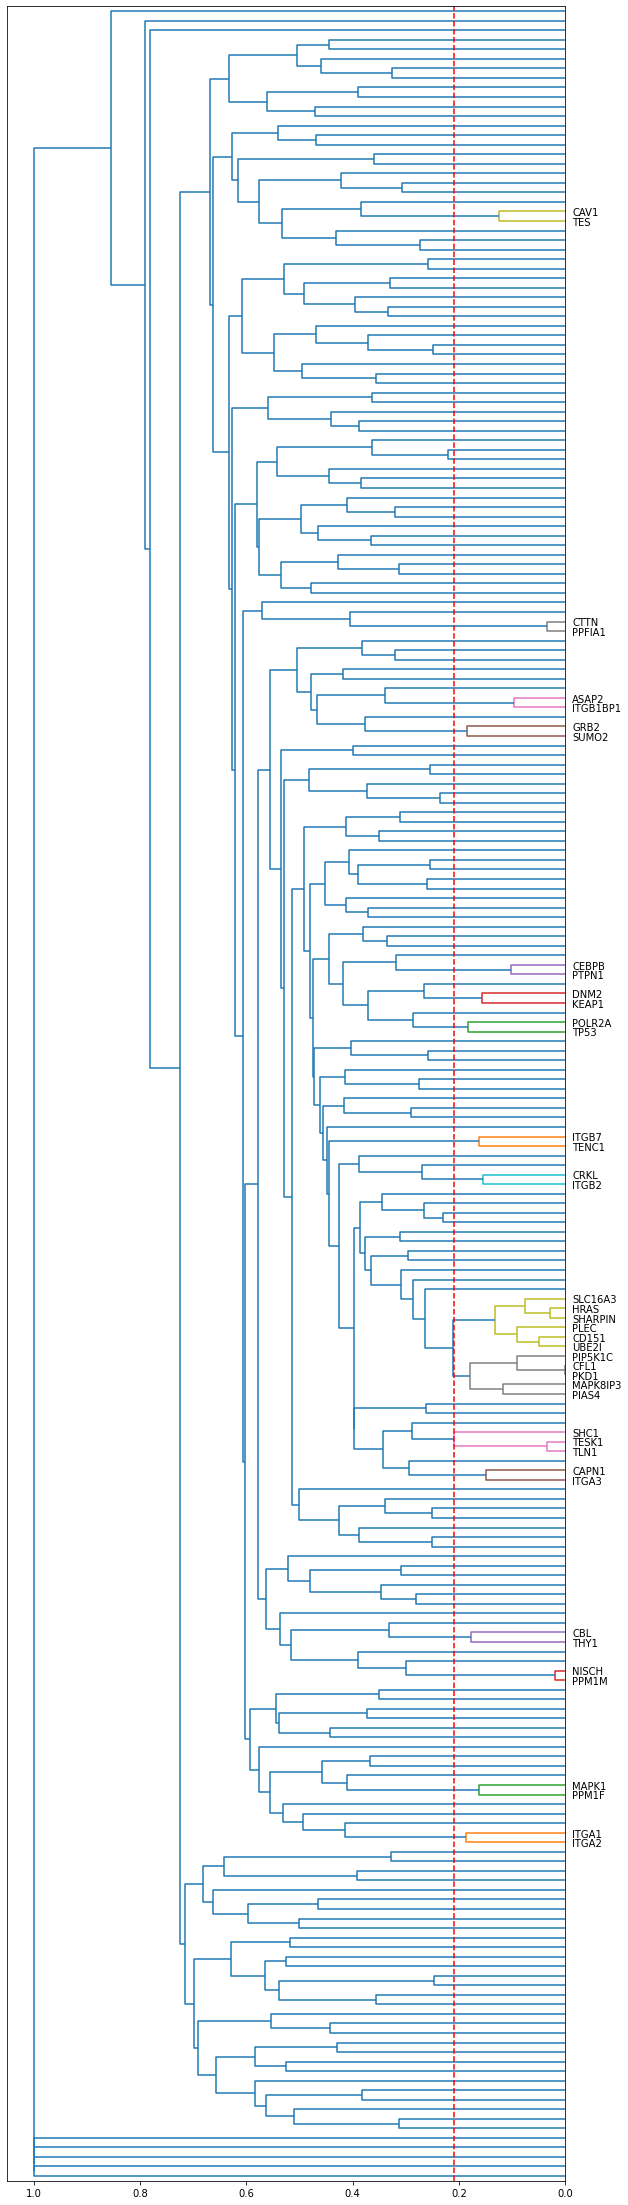

In [34]:
# Perform HC with average linkage
linked = linkage(y, method='average')
t = cc.get_4chrom_clustering(linked, sorted(G.nodes), gene2chrom)
clust = fcluster(linked, t, criterion='distance')
# Call dendrogram to get the returned dictionary and compute label function
R1 = dendrogram(linked, labels=sorted(G.nodes), no_plot=True)
R2 = []
for i in range(len(R1['ivl'])):
    if (R1['ivl'][i] in nonsingleton_genes):
        R2.append(R1['ivl'][i])
    else:
        R2.append('')
# Create a label dictionary
temp = {
    R1['leaves'][ii]: R2[ii] 
    for ii in range(len(R1['leaves']))
}
def llf(xx):
    return temp[xx]

plt.figure(figsize=(10, 40))
dendrogram(linked1,
            orientation='left',
            labels=sorted(G.nodes),
            distance_sort='descending',
            leaf_font_size=10,
            leaf_label_func=llf,
            color_threshold=t)
plt.vlines(x=t, ymin=0, ymax=4000, color='red', linestyle='dashed')
plt.show()

Number of singletons = 186
Number of non-singleton clusters = 17


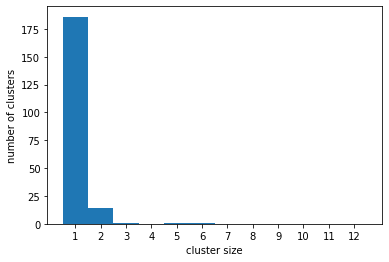

,gene,chrom,unique_chrom,size,adhesome,TFs,prop_adhesome_targets,prop_genome_targets,TF_adhesome_targets
cluster,,,,,,,,,
120,"[CD151, HRAS, PLEC, SHARPIN, SLC16A3, UBE2I]","[chr11, chr11, chr8, chr8, chr17, chr16]","{chr8, chr16, chr17, chr11}",6,"[CD151, HRAS, PLEC, SHARPIN, SLC16A3]",[UBE2I],[0.01],[0.002],"[[HRAS, TGFB1I1]]"
121,"[CFL1, MAPK8IP3, PIAS4, PIP5K1C, PKD1]","[chr11, chr16, chr19, chr19, chr16]","{chr19, chr16, chr11}",5,"[CFL1, MAPK8IP3, PIP5K1C, PKD1]",[PIAS4],[0.005],[0.004],[[PAK1]]
127,"[SHC1, TESK1, TLN1]","[chr1, chr9, chr9]","{chr1, chr9}",3,"[SHC1, TESK1, TLN1]",[],[],[],[]
18,"[CAV1, TES]","[chr7, chr7]",{chr7},2,"[CAV1, TES]",[],[],[],[]
159,"[MAPK1, PPM1F]","[chr22, chr22]",{chr22},2,"[MAPK1, PPM1F]",[],[],[],[]
147,"[NISCH, PPM1M]","[chr3, chr3]",{chr3},2,"[NISCH, PPM1M]",[],[],[],[]
145,"[CBL, THY1]","[chr11, chr11]",{chr11},2,"[CBL, THY1]",[],[],[],[]
129,"[CAPN1, ITGA3]","[chr11, chr17]","{chr17, chr11}",2,"[CAPN1, ITGA3]",[],[],[],[]
109,"[CRKL, ITGB2]","[chr22, chr21]","{chr21, chr22}",2,"[CRKL, ITGB2]",[],[],[],[]


In [35]:
# Get clustering dataframe
clustering_hic_df = pd.DataFrame({'gene': sorted(G.nodes),
                                  'chrom': [gene2chrom[g] for g in sorted(G.nodes)],
                                  'cluster': clust})
clustering_hic_df = clustering_hic_df.groupby('cluster').agg({'gene': lambda x: list(x),
                                                              'chrom': lambda x: list(x)})
clustering_hic_df['unique_chrom'] = [set(ls) for ls in clustering_hic_df['chrom']]
clustering_hic_df['size'] = [len(ls) for ls in clustering_hic_df['gene']]

# Add adhesome, TF annotations and specificity
clustering_hic_df['adhesome'] = [[g for g in clustering_hic_df.iloc[i]['gene'] if g in active_adhesome_genes] 
                            for i in range(len(clustering_hic_df))]
clustering_hic_df['TFs'] = [[g for g in clustering_hic_df.iloc[i]['gene'] if g in active_lung_adhesome_tf_genes] 
                            for i in range(len(clustering_hic_df))]
clustering_hic_df['prop_adhesome_targets'] =[[np.round(len(active_lung_tf2target[tf].intersection(set(active_adhesome_genes)))/len(active_adhesome_genes),3) 
                                              for tf in tf_list]
                                              for tf_list in clustering_hic_df['TFs']]
clustering_hic_df['prop_genome_targets'] =[[np.round(len(active_lung_tf2target[tf].intersection(set(all_active_genes)))/len(all_active_genes),3) 
                                            for tf in tf_list]
                                            for tf_list in clustering_hic_df['TFs']]

# Show statistics
print('Number of singletons = '+str(len(clustering_hic_df[clustering_hic_df['size']==1])))
print('Number of non-singleton clusters = '+str(len(clustering_hic_df[clustering_hic_df['size']>1])))
plt.figure()
clustering_hic_df['size'].plot.hist(bins=np.arange(0.5,13.5,1))
plt.xlabel('cluster size')
plt.ylabel('number of clusters')
plt.xticks(np.arange(1,13))
plt.show()

# Only select non singleton clusters
clustering_hic_df = clustering_hic_df[clustering_hic_df['size']>1]
clustering_hic_df = clustering_hic_df.sort_values(by='size', ascending=False)
clustering_hic_df['TF_adhesome_targets'] = [
    [sorted(active_lung_tf2target[tf].intersection(set(active_adhesome_genes))) 
#      if len(active_lung_tf2target[tf].intersection(set(active_adhesome_genes)))<10
#      else {'lld'}
     for tf in clustering_hic_df.loc[c,'TFs']
    ] 
    for c in clustering_hic_df.index]
clustering_hic_df

## Check using regulatory features

In [39]:
# Define graph from adhesome edge list with metadata
G = nx.from_pandas_edgelist(adhesome_edge_list, edge_attr=['hic','scaled_hic',
                                                           'pearson_dist','spearman_dist',
                                                           'cosine_dist'])
G.add_nodes_from(selected_genes)

In [40]:
# Obtain adjacency matrix based on scaled_hic
A = np.array(nx.adjacency_matrix(G, nodelist=sorted(G.nodes), weight='scaled_hic').todense())
np.fill_diagonal(A,1)
A = pd.DataFrame(A, index=sorted(G.nodes), columns=sorted(G.nodes))
# Compute HiC strength of each cluster
hic_strength = []
for c in clustering_hic_df.index:
    genes = clustering_hic_df.loc[c,'gene']
    hic_strength.append(np.mean(A.loc[genes,genes].values[np.triu_indices(n=len(genes), k=1)]))
clustering_hic_df['hic_strength'] = hic_strength

In [41]:
# Obtain adjacency matrix based on regulatory features
A = 1-np.array(nx.adjacency_matrix(G, nodelist=sorted(G.nodes), weight='spearman_dist').todense())
np.fill_diagonal(A,1)
A = pd.DataFrame(A, index=sorted(G.nodes), columns=sorted(G.nodes))
# Compute regulatory strength of each cluster
reg_strength = []
for c in clustering_hic_df.index:
    genes = clustering_hic_df.loc[c,'gene']
    reg_strength.append(np.mean(A.loc[genes,genes].values[np.triu_indices(n=len(genes), k=1)]))
clustering_hic_df['reg_strength'] = reg_strength

In [42]:
clustering_hic_df

,gene,chrom,unique_chrom,size,adhesome,TFs,prop_adhesome_targets,prop_genome_targets,TF_adhesome_targets,hic_strength,reg_strength
cluster,,,,,,,,,,,
120,"[CD151, HRAS, PLEC, SHARPIN, SLC16A3, UBE2I]","[chr11, chr11, chr8, chr8, chr17, chr16]","{chr16, chr17, chr11, chr8}",6,"[CD151, HRAS, PLEC, SHARPIN, SLC16A3]",[UBE2I],[0.01],[0.002],"[[HRAS, TGFB1I1]]",0.893638,0.690943
121,"[CFL1, MAPK8IP3, PIAS4, PIP5K1C, PKD1]","[chr11, chr16, chr19, chr19, chr16]","{chr16, chr11, chr19}",5,"[CFL1, MAPK8IP3, PIP5K1C, PKD1]",[PIAS4],[0.005],[0.004],[[PAK1]],0.863036,0.609748
127,"[SHC1, TESK1, TLN1]","[chr1, chr9, chr9]","{chr9, chr1}",3,"[SHC1, TESK1, TLN1]",[],[],[],[],0.848432,0.583261
18,"[CAV1, TES]","[chr7, chr7]",{chr7},2,"[CAV1, TES]",[],[],[],[],0.875783,0.891392
159,"[MAPK1, PPM1F]","[chr22, chr22]",{chr22},2,"[MAPK1, PPM1F]",[],[],[],[],0.837828,0.702942
147,"[NISCH, PPM1M]","[chr3, chr3]",{chr3},2,"[NISCH, PPM1M]",[],[],[],[],0.980953,0.645897
145,"[CBL, THY1]","[chr11, chr11]",{chr11},2,"[CBL, THY1]",[],[],[],[],0.821954,0.700391
129,"[CAPN1, ITGA3]","[chr11, chr17]","{chr17, chr11}",2,"[CAPN1, ITGA3]",[],[],[],[],0.850165,0.593899
109,"[CRKL, ITGB2]","[chr22, chr21]","{chr22, chr21}",2,"[CRKL, ITGB2]",[],[],[],[],0.845182,0.356980


In [43]:
# Derive a null distribution for regulatory strength of clusters
null_dist_dict = {n: [] for n in np.arange(2,8)}

np.random.seed(13)
for _ in tqdm(range(1000)):
    for n_genes in np.arange(2,8):
        random_genes = np.random.choice(all_active_genes, size=n_genes, replace=False)
        df_random = df_all_norm.loc[:,random_genes]
        df_random_corr = (1+df_random.corr(method='spearman'))/2
        null_dist_dict[n_genes].append(np.mean(df_random_corr.values[np.triu_indices(n=len(random_genes), k=1)]))
null_dist_dict = {key: np.array(val) for key, val in null_dist_dict.items()}

100%|██████████| 1000/1000 [00:08<00:00, 112.70it/s]


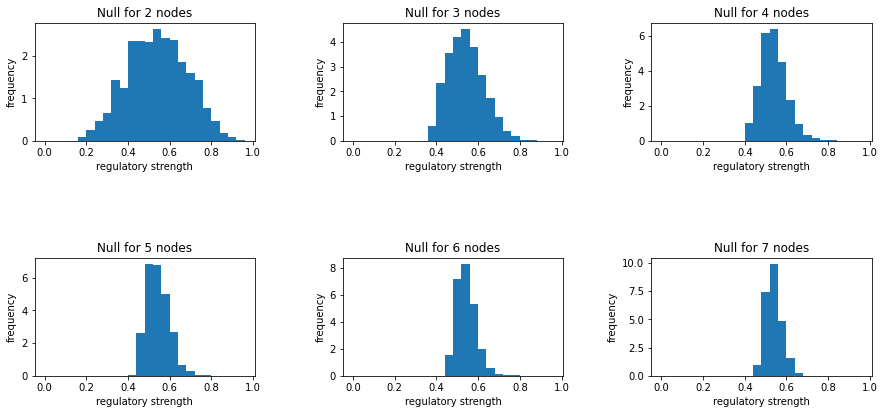

In [44]:
# Plot null distributions
i = 0
plt.figure(figsize=(15,5))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1, wspace=0.4)
for key, _ in null_dist_dict.items():
    i+=1
    plt.subplot(2, 3, i)
    plt.hist(null_dist_dict[key], bins=np.arange(0,1,0.04), density=True)
    plt.xlabel('regulatory strength')
    plt.ylabel('frequency')
    plt.title('Null for '+str(key)+' nodes')
plt.show()

In [46]:
# Compute regulatory p-value for each cluster
clustering_hic_df['pval'] = [
    np.mean(null_dist_dict[clustering_hic_df.iloc[i]['size']]>clustering_hic_df.iloc[i]['reg_strength']) 
                             for i in range(len(clustering_hic_df))
]
clustering_hic_df['significant cluster'] = clustering_hic_df['pval']<0.1
clustering_hic_df = clustering_hic_df.sort_values(by='pval', ascending=True)
clustering_hic_df = clustering_hic_df.reset_index()
clustering_hic_df

,index,cluster,gene,chrom,unique_chrom,size,adhesome,TFs,prop_adhesome_targets,prop_genome_targets,TF_adhesome_targets,hic_strength,reg_strength,pval,significant cluster
0,0,18,"[CAV1, TES]","[chr7, chr7]",{chr7},2,"[CAV1, TES]",[],[],[],[],0.875783,0.891392,0.003,True
1,1,120,"[CD151, HRAS, PLEC, SHARPIN, SLC16A3, UBE2I]","[chr11, chr11, chr8, chr8, chr17, chr16]","{chr16, chr17, chr11, chr8}",6,"[CD151, HRAS, PLEC, SHARPIN, SLC16A3]",[UBE2I],[0.01],[0.002],"[[HRAS, TGFB1I1]]",0.893638,0.690943,0.006,True
2,2,161,"[ITGA1, ITGA2]","[chr5, chr5]",{chr5},2,"[ITGA1, ITGA2]",[],[],[],[],0.813994,0.840480,0.011,True
3,3,59,"[CTTN, PPFIA1]","[chr11, chr11]",{chr11},2,"[CTTN, PPFIA1]",[],[],[],[],0.965357,0.816218,0.021,True
4,4,69,"[GRB2, SUMO2]","[chr17, chr17]",{chr17},2,[GRB2],[SUMO2],[0.228],[0.156],"[[ACTB, ARF1, ARHGEF12, ASAP2, BCAR1, BCAR3, C...",0.815202,0.749620,0.072,True
5,5,121,"[CFL1, MAPK8IP3, PIAS4, PIP5K1C, PKD1]","[chr11, chr16, chr19, chr19, chr16]","{chr16, chr11, chr19}",5,"[CFL1, MAPK8IP3, PIP5K1C, PKD1]",[PIAS4],[0.005],[0.004],[[PAK1]],0.863036,0.609748,0.114,False
6,6,67,"[ASAP2, ITGB1BP1]","[chr2, chr2]",{chr2},2,"[ASAP2, ITGB1BP1]",[],[],[],[],0.903006,0.709129,0.132,False
7,7,159,"[MAPK1, PPM1F]","[chr22, chr22]",{chr22},2,"[MAPK1, PPM1F]",[],[],[],[],0.837828,0.702942,0.139,False
8,8,145,"[CBL, THY1]","[chr11, chr11]",{chr11},2,"[CBL, THY1]",[],[],[],[],0.821954,0.700391,0.141,False
9,9,95,"[DNM2, KEAP1]","[chr19, chr19]",{chr19},2,"[DNM2, KEAP1]",[],[],[],[],0.842709,0.669887,0.194,False


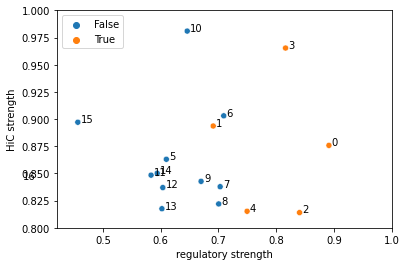

In [47]:
# Plot clusters in hic_strength/reg_strength space
plt.figure()
sns.scatterplot(x='reg_strength', y='hic_strength', hue='significant cluster', data=clustering_hic_df)
for c in clustering_hic_df.index:
    plt.text(clustering_hic_df.loc[c,'reg_strength']+0.005,
             clustering_hic_df.loc[c,'hic_strength']+0, 
             c)
plt.xlim([0.42,1])
plt.ylim([0.80,1])
plt.xlabel('regulatory strength')
plt.ylabel('HiC strength')
plt.legend(loc='upper left')
plt.show()

In [48]:
# Select clusters that show strong coregulation
clustering_hic_df.to_csv(saving_dir+'clustering_hic_df.csv')
pval_threshold = 0.10
clustering_hic_df = clustering_hic_df[clustering_hic_df['pval']<pval_threshold]
clustering_hic_df

,index,cluster,gene,chrom,unique_chrom,size,adhesome,TFs,prop_adhesome_targets,prop_genome_targets,TF_adhesome_targets,hic_strength,reg_strength,pval,significant cluster
0,0,18,"[CAV1, TES]","[chr7, chr7]",{chr7},2,"[CAV1, TES]",[],[],[],[],0.875783,0.891392,0.003,True
1,1,120,"[CD151, HRAS, PLEC, SHARPIN, SLC16A3, UBE2I]","[chr11, chr11, chr8, chr8, chr17, chr16]","{chr16, chr17, chr11, chr8}",6,"[CD151, HRAS, PLEC, SHARPIN, SLC16A3]",[UBE2I],[0.01],[0.002],"[[HRAS, TGFB1I1]]",0.893638,0.690943,0.006,True
2,2,161,"[ITGA1, ITGA2]","[chr5, chr5]",{chr5},2,"[ITGA1, ITGA2]",[],[],[],[],0.813994,0.840480,0.011,True
3,3,59,"[CTTN, PPFIA1]","[chr11, chr11]",{chr11},2,"[CTTN, PPFIA1]",[],[],[],[],0.965357,0.816218,0.021,True
4,4,69,"[GRB2, SUMO2]","[chr17, chr17]",{chr17},2,[GRB2],[SUMO2],[0.228],[0.156],"[[ACTB, ARF1, ARHGEF12, ASAP2, BCAR1, BCAR3, C...",0.815202,0.749620,0.072,True


In [49]:
# Create dictionary mapping cluster ID (index of clustering_hic_df) to cluster
id2cluster = {i: ','.join(clustering_hic_df.loc[i,'gene']) for i in clustering_hic_df.index}
cluster2id = {','.join(clustering_hic_df.loc[i,'gene']): i for i in clustering_hic_df.index}

#  Build network of clusters

In [50]:
# Build network of clusters
edge_list = pd.DataFrame(columns=['source','target','source_id','target_id','weight','TFs'])
for i in range(len(clustering_hic_df)):
    for j in range(len(clustering_hic_df)):
        # Cluster nodes
        cluster1 = cc.format_node_label(clustering_hic_df.iloc[i]['gene'])
        cluster2 = cc.format_node_label(clustering_hic_df.iloc[j]['gene'])
        # Clusters ID
        cluster1_id = clustering_hic_df.index.values[i]
        cluster2_id = clustering_hic_df.index.values[i]
        # Nodes in clusters
        cluster1_tfs = clustering_hic_df.iloc[i]['TFs']
        cluster2_nodes = clustering_hic_df.iloc[j]['gene']
        # Normalized edge weight
        n_target_genes = len(cluster2_nodes)
        n_tf_genes = len(cluster1_tfs)
        if n_tf_genes>0: 
            tfs_involved_in_edge = [tf for tf in cluster1_tfs
                                    if len(active_lung_tf2target[tf].intersection(set(cluster2_nodes)))>0]
            tfs_targets = [sorted(active_lung_tf2target[tf].intersection(set(cluster2_nodes))) 
                           for tf in tfs_involved_in_edge]
            weight = np.sum(np.array([len(active_lung_tf2target[cluster1_tfs[i]].intersection(set(cluster2_nodes)))
                                     for i in range(len(cluster1_tfs))]))/(n_target_genes*n_tf_genes)
            # Create edge
            new_edge = pd.DataFrame({'source': [cluster1],
                                     'target': [cluster2],                
                                     'source_id': [cluster1_id],
                                     'target_id': [cluster2_id],
                                     'weight':[weight],
                                     'TFs': [','.join(tfs_involved_in_edge)],
                                     'TF_targets': [tfs_targets]})
            edge_list = edge_list.append(new_edge)
edge_list = edge_list[edge_list['weight']>0]

In [51]:
# Create graph
G = nx.from_pandas_edgelist(edge_list, edge_attr=['weight','TFs'], create_using=nx.DiGraph)
G.add_nodes_from([cc.format_node_label(clustering_hic_df.iloc[i]['gene']) for i in range(len(clustering_hic_df))])
# Add node metadata
n = len(clustering_hic_df)
nx.set_node_attributes(G, 
        {cc.format_node_label(clustering_hic_df.iloc[i]['gene']): len(clustering_hic_df.iloc[i]['adhesome']) for i in range(n)}, 
                       "n_adhesome")
nx.set_node_attributes(G, 
        {cc.format_node_label(clustering_hic_df.iloc[i]['gene']): len(clustering_hic_df.iloc[i]['TFs']) for i in range(n)}, 
                       "n_TFs")
nx.set_node_attributes(G, 
        {cc.format_node_label(clustering_hic_df.iloc[i]['gene']): clustering_hic_df.iloc[i]['adhesome'] for i in range(n)}, 
                       "all_adhesomes")
nx.set_node_attributes(G, 
        {cc.format_node_label(clustering_hic_df.iloc[i]['gene']): clustering_hic_df.iloc[i]['TFs'] for i in range(n)}, 
                       "all_TFs")
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 5
Number of edges: 4
Average in degree:   0.8000
Average out degree:   0.8000


In [52]:
reload(cc)
# Define network object
net  = Network(height="1000px",
               width="1000px",
               directed=True,
               font_color='black',
               notebook=True,
               layout=None,
               heading='Adhesome network')

# Set layout
net.hrepulsion(node_distance=300,
               central_gravity=0.0,
               spring_length=100,
               spring_strength=0.01,
               damping=0.09)

net.toggle_physics(False)

# Import NetworkX graph
cc.from_nx(G, net, default_node_size=20, 
        default_edge_weight=1,edge_weight_scale=0.1, edge_color_scale=1, edge_threshold=0, 
        hidden_edges=[],
        shape='box')
#net.show_buttons()
net.show("adhesome_network.html")

In [53]:
# Nicer version of edge list for display
edge_list_todisplay = edge_list.copy()
edge_list_todisplay['source'] = edge_list_todisplay['source'].str.replace(' \n ', '').str.replace(' ', ',')
edge_list_todisplay['target'] = edge_list_todisplay['target'].str.replace(' \n ', '').str.replace(' ', ',')
edge_list_todisplay['source_id'] = [cluster2id[c] for c in edge_list_todisplay['source']]
edge_list_todisplay['target_id'] = [cluster2id[c] for c in edge_list_todisplay['target']]
edge_list_todisplay = edge_list_todisplay[['source_id', 'target_id', 'weight', 'TFs', 'TF_targets']]
edge_list_todisplay.to_csv(saving_dir+'edge_list_todisplay.csv')
edge_list_todisplay.head()

,source_id,target_id,weight,TFs,TF_targets
0,1,1,0.166667,UBE2I,[[HRAS]]
0,4,0,1.000000,SUMO2,"[[CAV1, TES]]"
0,4,1,0.333333,SUMO2,"[[PLEC, UBE2I]]"
0,4,4,0.500000,SUMO2,[[SUMO2]]


In [54]:
# Correspondance between cluster and cluster ID
clusters_map = pd.DataFrame({'cluster_id': list(id2cluster.keys()),
                             'genes': list(id2cluster.values())})
clusters_map.to_csv(saving_dir+'clusters_map.csv')
clusters_map

,cluster_id,genes
0,0,"CAV1,TES"
1,1,"CD151,HRAS,PLEC,SHARPIN,SLC16A3,UBE2I"
2,2,"ITGA1,ITGA2"
3,3,"CTTN,PPFIA1"
4,4,"GRB2,SUMO2"


## TFs in selected clusters

In [55]:
# Spot TFs in our clusters
all_genes_in_clusters = np.array(list(itertools.chain.from_iterable([genes.split(',') 
                                                                     for genes in clusters_map['genes'].values])))
all_lungfibroTFs = tftarget_df_lungfibro['tf'].unique()
all_tfs_in_clusters = np.array(list(set(all_genes_in_clusters).intersection(set(all_lungfibroTFs))))

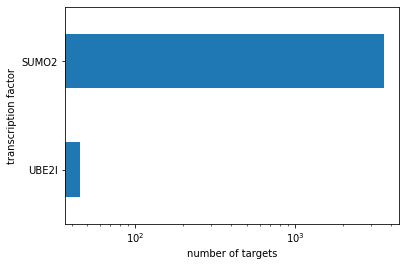

In [56]:
# Plot 
barplot_data = tftarget_df_lungfibro[tftarget_df_lungfibro['tf'].isin(all_tfs_in_clusters)]
barplot_data = barplot_data.drop_duplicates(subset=['tf', 'target_gene'])
barplot_data = barplot_data.groupby(['tf'])
barplot_data = barplot_data['target_gene'].count().sort_values()
plt.figure()
barplot_data = barplot_data.plot.barh()
plt.xscale('log')
plt.xlabel('number of targets')
plt.ylabel('transcription factor')
plt.show()

In [330]:
# Construct network
genes2remove = [] # np.array(['ROCK1', 'RBL1','PVR','ITGB1','PRNP'])
inter_selected = adhesome_interX_edge_list.copy()
inter_selected = inter_selected[inter_selected['scaled_hic']>0]
intra_selected = adhesome_intraX_edge_list.copy()
intra_selected = intra_selected[['source','target','hic','scaled_hic',
                                 'pearson_dist','spearman_dist',
                                 'cosine_dist']]
intra_selected = intra_selected[intra_selected['scaled_hic']>0]
adhesome_edge_list = pd.concat([inter_selected,intra_selected], axis=0)
adhesome_edge_list = adhesome_edge_list[(~adhesome_edge_list['source'].isin(genes2remove)) &
                                        (~adhesome_edge_list['target'].isin(genes2remove))]
G = nx.from_pandas_edgelist(adhesome_edge_list, edge_attr=['hic','scaled_hic',
                                                           'pearson_dist','spearman_dist',
                                                           'cosine_dist'])
#G.add_nodes_from(selected_genes)

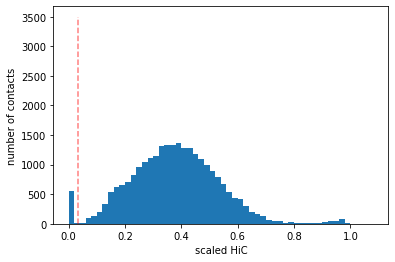

In [292]:
# Identify the smallest non-zero scaled_hic value
all_hic_values = np.array(nx.adjacency_matrix(G, nodelist=sorted(G.nodes), weight='scaled_hic').todense())
all_hic_values = all_hic_values[np.tril_indices(len(all_hic_values),1)]
all_nonzero_hic_values = all_hic_values[np.nonzero(all_hic_values)]
min_nonzero_hic = np.min(all_nonzero_hic_values)
plt.figure()
plt.hist(all_hic_values, bins=np.arange(0,1.1,0.02))
plt.vlines(x=min_nonzero_hic, ymin=0, ymax=3500, color='red', linestyle='dashed', alpha=0.5)
plt.xlabel('scaled HiC')
plt.ylabel('number of contacts')
plt.show()

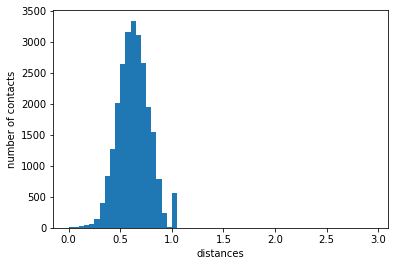

In [303]:
# Construct distance matrix
c = min_nonzero_hic/2
dist_hic = 1-np.array(nx.adjacency_matrix(G, nodelist=sorted(G.nodes), weight='scaled_hic').todense())
#dist_hic = np.log10((1+c)/(dist_hic+c))
np.fill_diagonal(dist_hic,0)
y = dist_hic[np.triu_indices(n=len(dist_hic),k=1)]
plt.figure()
plt.hist(y, bins=np.arange(0,3,0.05))
plt.xlabel('distances')
plt.ylabel('number of contacts')
plt.show()

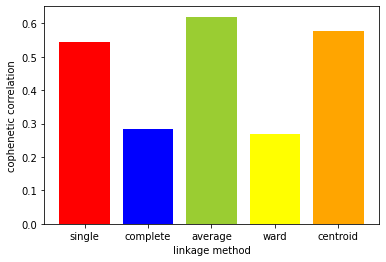

In [322]:
# Check which is the best technique in terms of cophenetic correlation
cophenet_single = cophenet(linkage(y, method='single'), y)[0]
cophenet_complete = cophenet(linkage(y, method='complete'), y)[0]
cophenet_average = cophenet(linkage(y, method='average'), y)[0]
cophenet_ward = cophenet(linkage(y, method='ward'), y)[0]
cophenet_centroid = cophenet(linkage(y, method='centroid'), y)[0]
plt.figure()
plt.bar(x=['single', 'complete', 'average', 'ward', 'centroid'],
        height = [cophenet_single, cophenet_complete, cophenet_average, cophenet_ward, cophenet_centroid],
        color = ['red', 'blue', 'yellowgreen', 'yellow', 'orange'])
plt.xlabel('linkage method')
plt.ylabel('cophenetic correlation')
plt.show()

In [305]:
# Build dendrogram using average linkage
linked_avg = linkage(y, method='average')

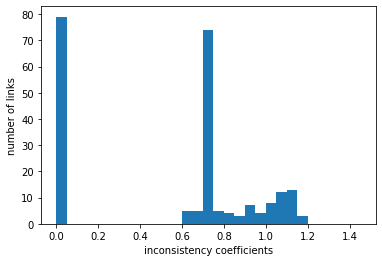

In [306]:
# Cluster using inconsistency
inconsist_coefs = inconsistent(linked_avg)[:,3]
plt.figure()
plt.hist(inconsist_coefs, bins=np.arange(0,1.5,0.05))
plt.xlabel('inconsistency coefficients')
plt.ylabel('number of links')
plt.show()

Chosen inconsistent coefficient = 0.83


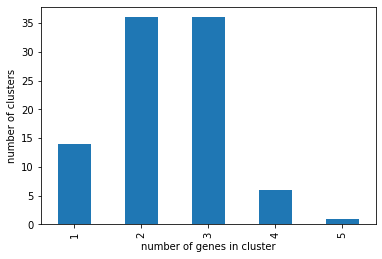

In [311]:
# Cluster using inconsistency threshold
t = cc.get_4chrom_clustering(linked_avg, sorted(G.nodes), gene2chrom, 
                              inc=0.01, max_chrom=4, criterion='inconsistent')
#t = 1
print(f'Chosen inconsistent coefficient = {t}')
clust = fcluster(linked_avg, t, criterion='inconsistent')
df = pd.DataFrame({'gene': sorted(G.nodes), 'cluster': clust})
df = df.set_index('gene')
plt.figure()
df.groupby('cluster')['cluster'].count().to_frame('n_genes').groupby('n_genes')['n_genes'].count().plot.bar()
plt.xlabel('number of genes in cluster')
plt.ylabel('number of clusters')
plt.show()

In [312]:
# Identify which nodes are in non-singleton clusters
gene_clusters_df = pd.DataFrame({'gene': sorted(G.nodes), 'cluster': clust})
nonsingleton_cluster_ids = set([c for c in list(clust) if list(clust).count(c)>1])
nonsingleton_genes = gene_clusters_df[gene_clusters_df['cluster'].isin(nonsingleton_cluster_ids)]['gene'].values

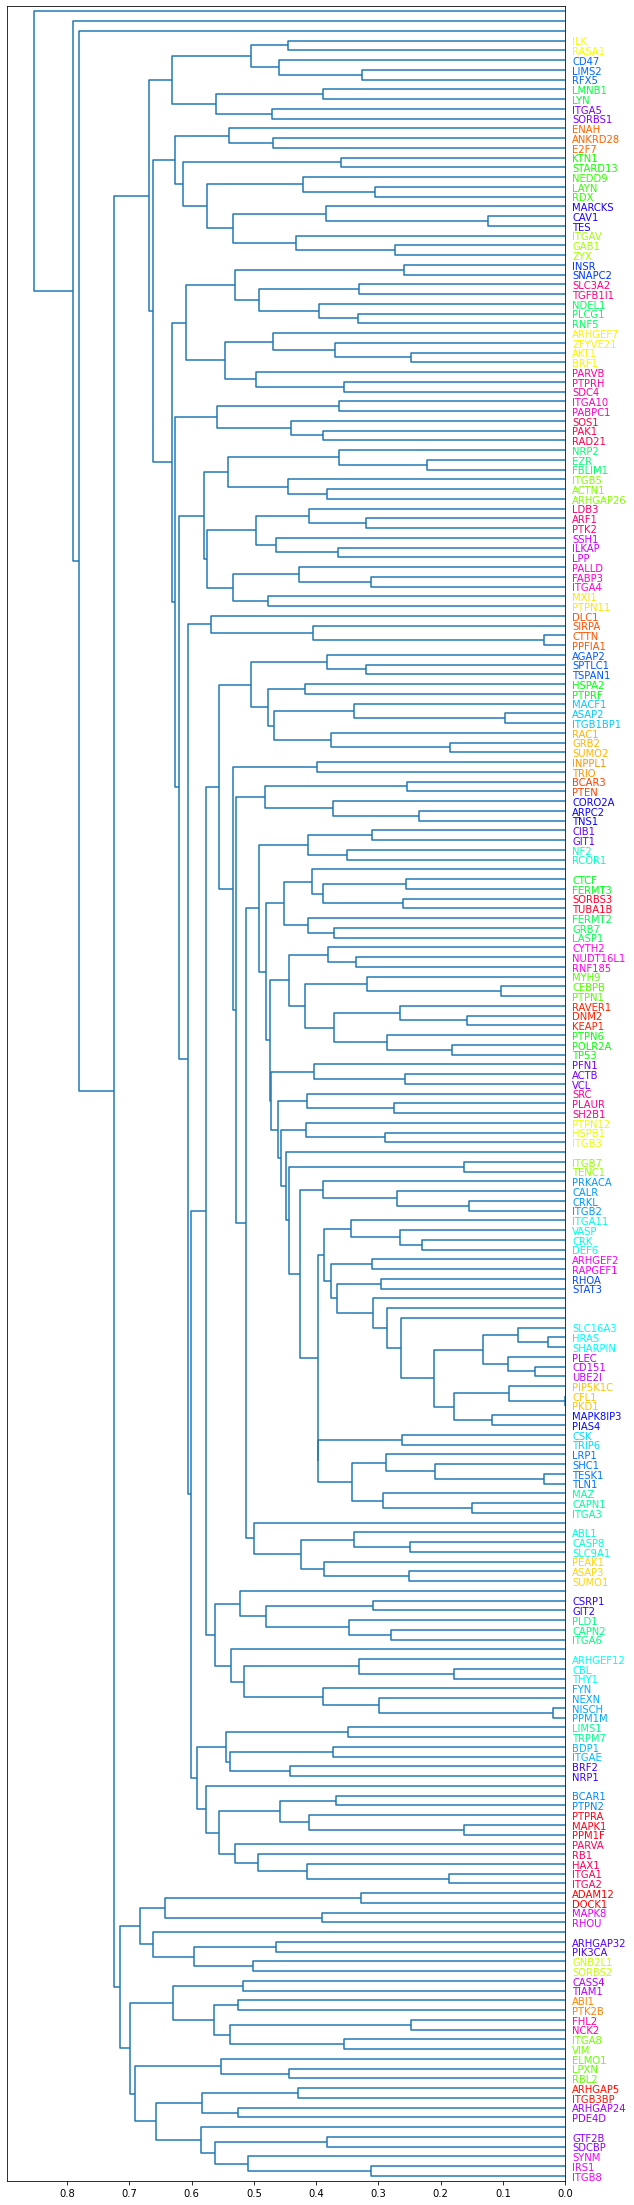

In [313]:
# Call dendrogram to get the returned dictionary and compute label function

# Build leaf label function
R1 = dendrogram(linked_avg, labels=sorted(G.nodes), no_plot=True)
R2 = []
for i in range(len(R1['ivl'])):
    if (R1['ivl'][i] in nonsingleton_genes):
        R2.append(R1['ivl'][i])
    else:
        R2.append('')
# Create a label dictionary
temp = {
    R1['leaves'][ii]: R2[ii] 
    for ii in range(len(R1['leaves']))
}
def llf(xx):
    return temp[xx]

# Build leaf color function
permutation = np.random.permutation(len(np.unique(clust)))
df['cluster'] = permutation[df['cluster'].values-1]
my_color = {g: df.loc[g, 'cluster'] for g in df.index}
my_color[''] = 0
my_palette = plt.cm.get_cmap("hsv", len(np.unique(clust)))

# Plot dendrogram
plt.figure(figsize=(10, 40))
dendrogram(linked_avg,
            orientation='left',
            labels=sorted(G.nodes),
            distance_sort='descending',
            leaf_font_size=10,
            leaf_label_func=llf,
            color_threshold=0)
ax = plt.gca()
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(my_palette(my_color[lbl.get_text()]))
plt.show()

In [122]:
# Construct network

# Construct interX and intraX edge lists 
inter_selected = adhesome_interX_edge_list.copy()
inter_selected = inter_selected[inter_selected['scaled_hic']>0]
intra_selected = adhesome_intraX_edge_list.copy()
intra_selected = intra_selected[['source','target','hic','scaled_hic',
                                 'pearson_dist','spearman_dist',
                                 'cosine_dist']]

# Cobine interX and intraX edge lists
adhesome_edge_list = pd.concat([inter_selected,intra_selected], axis=0)
adhesome_edge_list = adhesome_edge_list[adhesome_edge_list['scaled_hic']>0]
adhesome_edge_list = adhesome_edge_list[adhesome_edge_list['source'] != adhesome_edge_list['target']]
adhesome_edge_list['log_hic'] = -np.log(adhesome_edge_list['scaled_hic'])
adhesome_edge_list['hic_dist'] = 1-adhesome_edge_list['scaled_hic']

# Creat network
G = nx.from_pandas_edgelist(adhesome_edge_list, edge_attr=['log_hic', 'hic_dist',
                                                           'pearson_dist','spearman_dist',
                                                           'cosine_dist'])

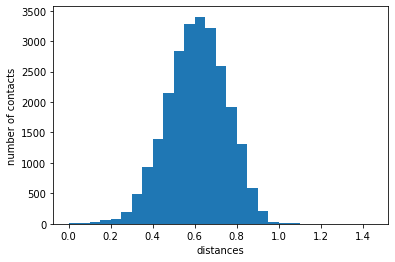

In [123]:
# Compute weighted distance matrix

len_path = dict(nx.all_pairs_dijkstra(G, weight='hic_dist'))
df_list = [pd.DataFrame(
    {'genes': sorted(G.nodes),
     g: [len_path[g][0][g1] for g1 in sorted(G.nodes)]}
                       ).set_index('genes')
           for g in sorted(G.nodes)]
dist_hic = pd.concat(df_list, axis=1)
dist_hic = dist_hic.values

# len_path = dict(nx.all_pairs_dijkstra(G, weight='log_hic'))
# df_list = [pd.DataFrame(
#     {'genes': sorted(G.nodes),
#      g: [np.exp(-len_path[g][0][g1]) for g1 in sorted(G.nodes)]}
#                        ).set_index('genes')
#            for g in sorted(G.nodes)]
# dist_hic = 1-pd.concat(df_list, axis=1)
# dist_hic = dist_hic.values

y = dist_hic[np.triu_indices(n=len(dist_hic),k=1)]
plt.figure()
plt.hist(y, bins=np.arange(0,1.5,0.05))
plt.xlabel('distances')
plt.ylabel('number of contacts')
plt.show()

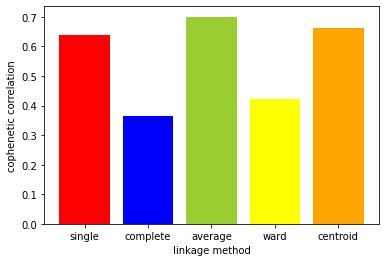

In [124]:
# Check which is the best technique in terms of cophenetic correlation
cophenet_single = cophenet(linkage(y, method='single'), y)[0]
cophenet_complete = cophenet(linkage(y, method='complete'), y)[0]
cophenet_average = cophenet(linkage(y, method='average'), y)[0]
cophenet_ward = cophenet(linkage(y, method='ward'), y)[0]
cophenet_centroid = cophenet(linkage(y, method='centroid'), y)[0]
plt.figure()
plt.bar(x=['single', 'complete', 'average', 'ward', 'centroid'],
        height = [cophenet_single, cophenet_complete, cophenet_average, cophenet_ward, cophenet_centroid],
        color = ['red', 'blue', 'yellowgreen', 'yellow', 'orange'])
plt.xlabel('linkage method')
plt.ylabel('cophenetic correlation')
plt.show()

In [125]:
# Build dendrogram using average linkage
linked_avg = linkage(y, method='average')

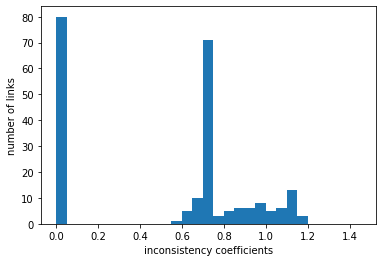

In [126]:
# Cluster using inconsistency
inconsist_coefs = inconsistent(linked_avg)[:,3]
plt.figure()
plt.hist(inconsist_coefs, bins=np.arange(0,1.5,0.05))
plt.xlabel('inconsistency coefficients')
plt.ylabel('number of links')
plt.show()

Chosen inconsistent coefficient = 0.91


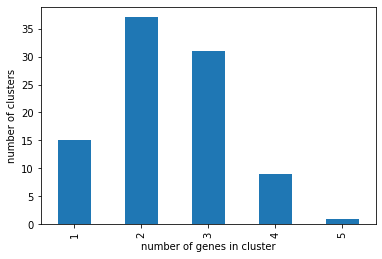

In [130]:
# Cluster using inconsistency threshold
criterion = 'inconsistent'
t = cc.get_4chrom_clustering(linked_avg, sorted(G.nodes), gene2chrom, 
                              inc=0.01, max_chrom=5, criterion=criterion)
#t = 1
print(f'Chosen inconsistent coefficient = {t}')
clust = fcluster(linked_avg, t, criterion=criterion)
df = pd.DataFrame({'gene': sorted(G.nodes), 'cluster': clust})
df = df.set_index('gene')
plt.figure()
df.groupby('cluster')['cluster'].count().to_frame('n_genes').groupby('n_genes')['n_genes'].count().plot.bar()
plt.xlabel('number of genes in cluster')
plt.ylabel('number of clusters')
plt.show()

In [131]:
# Identify which nodes are in non-singleton clusters
gene_clusters_df = pd.DataFrame({'gene': sorted(G.nodes), 'cluster': clust})
nonsingleton_cluster_ids = set([c for c in list(clust) if list(clust).count(c)>1])
nonsingleton_genes = gene_clusters_df[gene_clusters_df['cluster'].isin(nonsingleton_cluster_ids)]['gene'].values

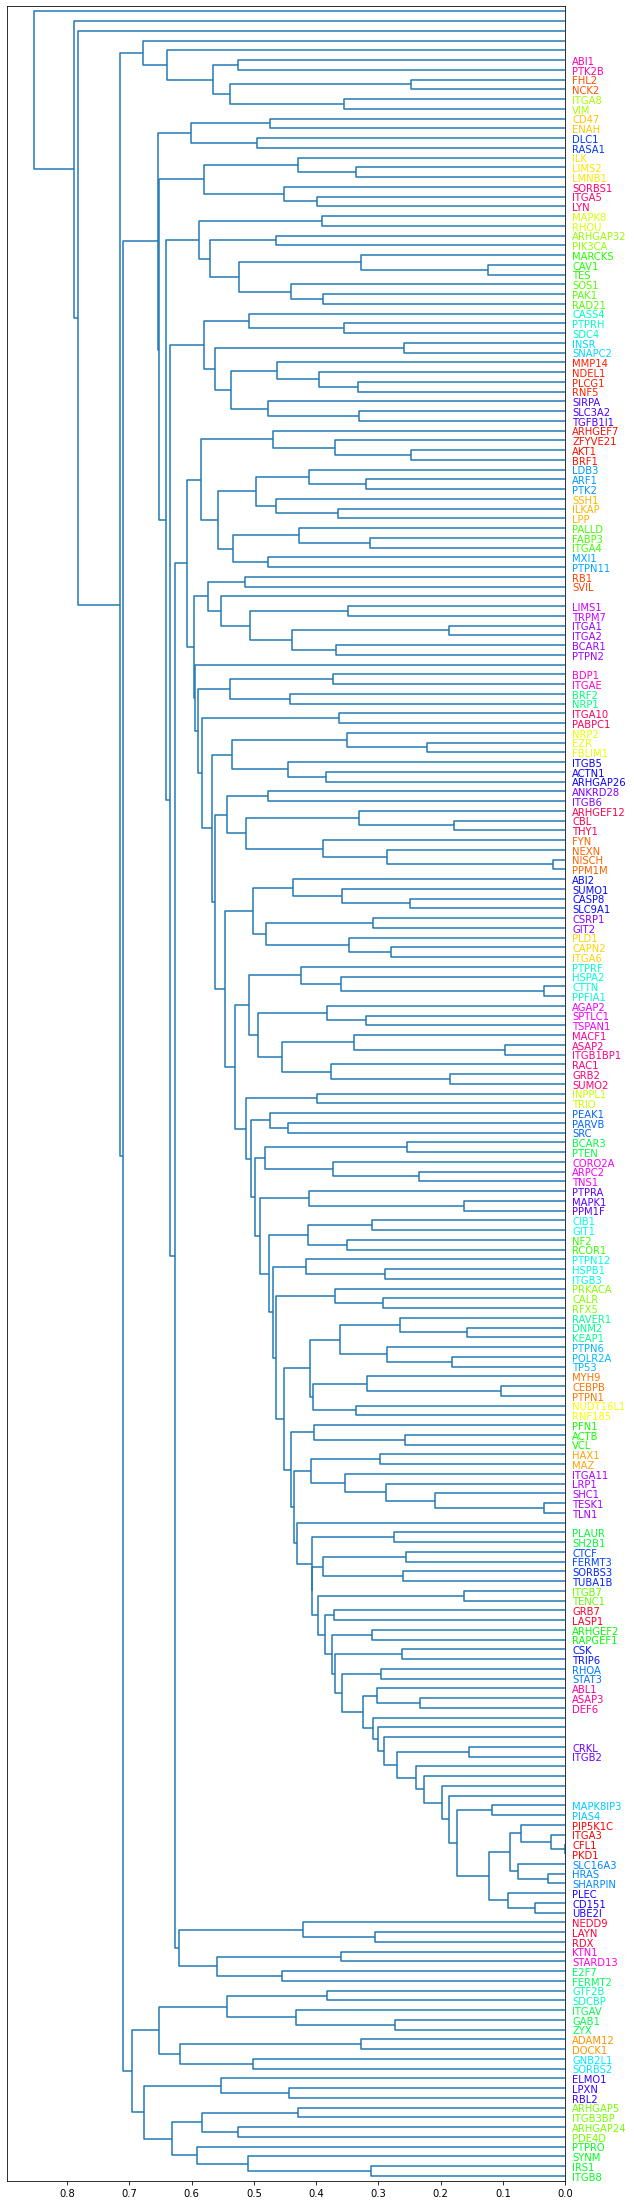

In [132]:
# Call dendrogram to get the returned dictionary and compute label function

# Build leaf label function
R1 = dendrogram(linked_avg, labels=sorted(G.nodes), no_plot=True)
R2 = []
for i in range(len(R1['ivl'])):
    if (R1['ivl'][i] in nonsingleton_genes):
        R2.append(R1['ivl'][i])
    else:
        R2.append('')
# Create a label dictionary
temp = {
    R1['leaves'][ii]: R2[ii] 
    for ii in range(len(R1['leaves']))
}
def llf(xx):
    return temp[xx]

# Build leaf color function
permutation = np.random.permutation(len(np.unique(clust)))
df['cluster'] = permutation[df['cluster'].values-1]
my_color = {g: df.loc[g, 'cluster'] for g in df.index}
my_color[''] = 0
my_palette = plt.cm.get_cmap("hsv", len(np.unique(clust)))

# Plot dendrogram
plt.figure(figsize=(10, 40))
dendrogram(linked_avg,
            orientation='left',
            labels=sorted(G.nodes),
            distance_sort='descending',
            leaf_font_size=10,
            leaf_label_func=llf,
            color_threshold=0)
ax = plt.gca()
xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(my_palette(my_color[lbl.get_text()]))
plt.show()

In [133]:
clusters_df = gene_clusters_df.groupby('cluster')['gene'].agg(list).to_frame()
clusters_df.columns = ['genes']
clusters_df['size'] = [len(c) for c in clusters_df['genes']]
clusters_df = clusters_df.sort_values('size', ascending=False)
for c in clusters_df['genes']:
    print(c)

['ITGA11', 'LRP1', 'SHC1', 'TESK1', 'TLN1']
['CTTN', 'HSPA2', 'PPFIA1', 'PTPRF']
['CFL1', 'ITGA3', 'PIP5K1C', 'PKD1']
['AKT1', 'ARHGEF7', 'BRF1', 'ZFYVE21']
['MMP14', 'NDEL1', 'PLCG1', 'RNF5']
['FYN', 'NEXN', 'NISCH', 'PPM1M']
['BCAR1', 'ITGA1', 'ITGA2', 'PTPN2']
['ABI2', 'CASP8', 'SLC9A1', 'SUMO1']
['ARHGAP24', 'ARHGAP5', 'ITGB3BP', 'PDE4D']
['IRS1', 'ITGB8', 'PTPRO', 'SYNM']
['AGAP2', 'SPTLC1', 'TSPAN1']
['CAPN2', 'ITGA6', 'PLD1']
['HSPB1', 'ITGB3', 'PTPN12']
['ASAP2', 'ITGB1BP1', 'MACF1']
['GRB2', 'RAC1', 'SUMO2']
['ARHGEF12', 'CBL', 'THY1']
['ABL1', 'ASAP3', 'DEF6']
['PARVB', 'PEAK1', 'SRC']
['ACTN1', 'ARHGAP26', 'ITGB5']
['EZR', 'FBLIM1', 'NRP2']
['CALR', 'PRKACA', 'RFX5']
['DNM2', 'KEAP1', 'RAVER1']
['HRAS', 'SHARPIN', 'SLC16A3']
['LAYN', 'NEDD9', 'RDX']
['CD151', 'PLEC', 'UBE2I']
['PAK1', 'RAD21', 'SOS1']
['ELMO1', 'LPXN', 'RBL2']
['ACTB', 'PFN1', 'VCL']
['ILK', 'LIMS2', 'LMNB1']
['ITGA5', 'LYN', 'SORBS1']
['GAB1', 'ITGAV', 'ZYX']
['MAPK1', 'PPM1F', 'PTPRA']
['CAV1', 'MARCKS', '